In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
#File selection for each generation

#Gen 1- Original Model Outputs
#labels_targets = torch.load('old_test_labels_targets.pt', weights_only=False)
#outputs_class = torch.load('old_test_outputs_class.pt', weights_only=False)
#outputs_targets = torch.load('old_test_outputs_targets.pt', weights_only=False)

#Gen 2 - Separated Model Outputs
#labels_targets = torch.load('Sep_test_labels_targets.pt', weights_only = False)
#outputs_class = torch.load('Sep_test_outputs_class.pt', weights_only = False)
#outputs_targets = torch.load('Sep_test_outputs_targets.pt', weights_only = False)

#Gen 3 - Large File outputs
#labels_targets = torch.load('128test_labels_targets.pt', weights_only = False)
#outputs_class = torch.load('128test_outputs_class.pt', weights_only = False)
#outputs_targets = torch.load('128test_outputs_targets.pt', weights_only = False)


#Small Files - Required for gen 1 or gen 2. Uncomment if analysing gen 1 or 2
#mean_scale = torch.load('hyperk_img/Gen1Gen2mean_scale.pt', weights_only = False)

#Large Files -  Required for gen 3. Uncomment if analysing gen 3
#mean_scale = torch.load('/home/mlproject2024/ml_project/data/hyperk_img_128x128_medium/Gen3mean_scale.pt', weights_only=False)

labels = labels_targets[:,0]
targets = labels_targets[:,1:5]

labels_targets.shape, outputs_class.shape, outputs_targets.shape, labels.shape, targets.shape

((15000, 8), (15000, 2), (15000, 4), (15000,), (15000, 4))

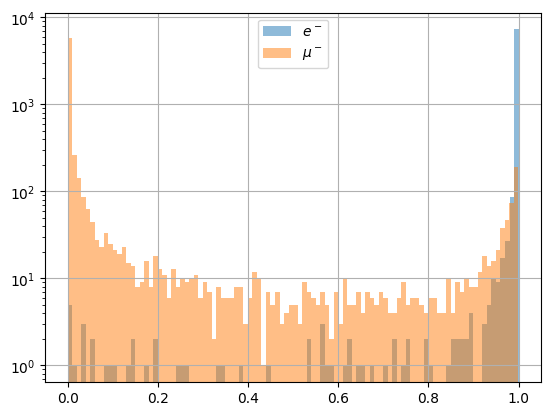

In [4]:
plt.hist(outputs_class[:,0][labels==0], bins=100, alpha=0.5, label=r'$e^-$')
plt.hist(outputs_class[:,0][labels==1], bins=100, alpha=0.5, label=r'$\mu^-$')
plt.grid()
plt.yscale('log')

plt.legend()
plt.show()

In [5]:
from torchmetrics.classification import BinaryAccuracy
import torch
accuracy_calc = BinaryAccuracy(threshold=0.5)
acc=accuracy_calc(torch.tensor(outputs_class[:,1]), torch.tensor(labels))
print('Accuracy: {:.1f} %'.format(acc*100.))

Accuracy: 95.3 %


In [6]:
from torchmetrics.classification import BinaryF1Score

f1score = BinaryF1Score(threshold=0.5)
f1s = f1score(torch.tensor(outputs_class[:,1]), torch.tensor(labels))
print('f1 score = {}%'.format(np.round(f1s*100)))

from torchmetrics.classification import BinaryPrecision
precision1 = BinaryPrecision()
prec1 = precision1(torch.tensor(outputs_class[:,1]), torch.tensor(labels))
print('Precision {:.1f} %'.format(prec1*100))

from torchmetrics.classification import BinaryRecall
recall1  = BinaryRecall()
recal1 = recall1(torch.tensor(outputs_class[:,1]), torch.tensor(labels))
print('Recall: {:.1f} %'.format(recal1*100))

from torchmetrics.classification import BinaryConfusionMatrix
ConfusionMatrix = BinaryConfusionMatrix()

confusionmatrix_result = ConfusionMatrix(torch.tensor(outputs_class[:,1]), torch.tensor(labels))
print('Confusion Matrix')
print(confusionmatrix_result)




f1 score = 95.0%
Precision 99.6 %
Recall: 91.0 %
Confusion Matrix
tensor([[7473,   27],
        [ 678, 6822]])


In [7]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(labels, outputs_class[:,1])
auc=roc_auc_score(labels, outputs_class[:,1])


In [8]:
#Particle separation

eevents = np.where(labels == 0) #Electron indices
mevents = np.where(labels == 1) #Muon indices

eoutputs_class = outputs_class[eevents]
moutputs_class = outputs_class[mevents]
eacc = accuracy_calc(torch.tensor(eoutputs_class[:,1]), torch.tensor(labels[eevents]))
macc = accuracy_calc(torch.tensor(moutputs_class[:,1]), torch.tensor(labels[mevents]))
print('Electron PID accuracy: {:.2f}%'.format(eacc*100))
print('Muon PID accuracy: {:.2f}%'.format(macc*100))


Electron PID accuracy: 99.64%
Muon PID accuracy: 90.96%


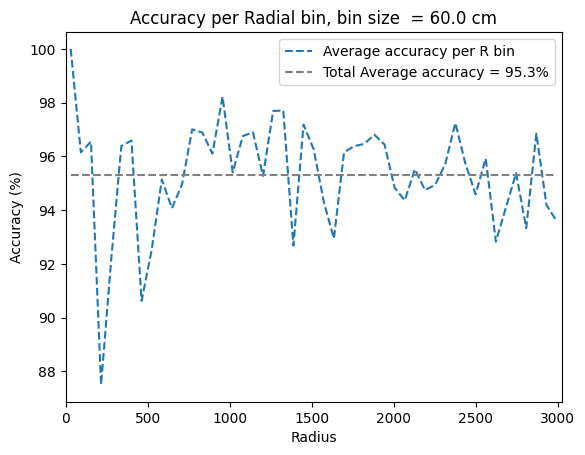

Text(0.5, 1.0, 'Number of events')

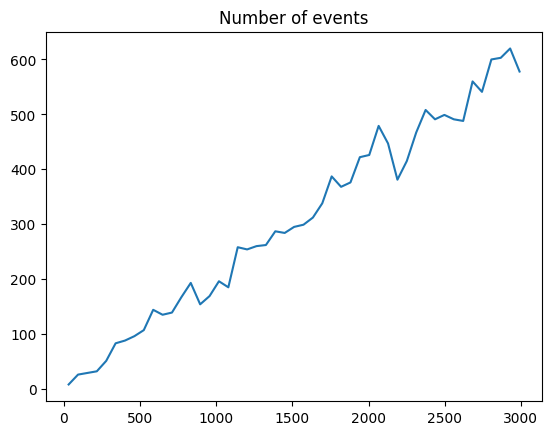

In [9]:
#Accuracy as a function of Wall Distance R

def cartesian_to_cylindrical(x, y, z):
    """
    Convert Cartesian coordinates to cylindrical coordinates.
    x, y, z: numpy arrays of Cartesian coordinates.
    Returns: rho, phi, z (cylindrical coordinates).
    """
    rho = np.sqrt(x**2 + y**2)          # Radial distance
    phi = np.arctan2(y, x)             # Angle in rads
    return rho, phi, z 

targets_scaled = targets*mean_scale['targets']['scale'][:4].numpy()+mean_scale['targets']['mean'][:4].numpy()
recons_scaled = outputs_targets*mean_scale['targets']['scale'][:4].numpy()+mean_scale['targets']['mean'][:4].numpy()

x_recons, y_recons, z_recons = recons_scaled[:, 1], recons_scaled[:, 2], recons_scaled[:, 3]
x_target, y_target, z_target = targets_scaled[:, 1], targets_scaled[:, 2], targets_scaled[:, 3]

rho_recons, phi_recons, z_recons = cartesian_to_cylindrical(x_recons, y_recons, z_recons)
rho_target, phi_target, z_target = cartesian_to_cylindrical(x_target, y_target, z_target)

#different method


bins = np.linspace(0, max(rho_target), 50)  


bin_indices = np.digitize(rho_target, bins)


split_radii = {i: [] for i in range(len(bins)-1)}
split_out = {i: [] for i in range(len(bins)-1)}
split_label = {i: [] for i in range(len(bins)-1)}


for i, bin_idx in enumerate(bin_indices):
    if 0 < bin_idx < len(bins):  
        split_radii[bin_idx-1].append(rho_target[i])
        split_out[bin_idx-1].append(outputs_class[i, 1])
        split_label[bin_idx-1].append(labels[i])


split_radii = {k: np.array(v) for k, v in split_radii.items()}
split_out = {k: np.array(v) for k, v in split_out.items()}
split_labels = {k: np.array(v) for k, v in split_label.items()}


acc_split = []
xplot = []
ymean = []
rnums = []
for k in split_radii:
    acc_split.append(accuracy_calc(torch.tensor(split_out[k]), torch.tensor(split_labels[k]))*100)
    xplot.append((bins[k]+bins[k+1])/2)
    ymean.append(acc*100)
    rnums.append(len(split_radii[k]))
    #print(f"Accuracy in region R = {np.round(bins[k])} - {np.round(bins[k+1])}cm: {np.round(acc_split[k])}%")

plt.plot(xplot, acc_split, linestyle = 'dashed', label = 'Average accuracy per R bin')
plt.plot(xplot, ymean, linestyle = 'dashed', color = 'grey', label = 'Total Average accuracy = {:.1f}%'.format(acc*100))
plt.xlim(0, max(rho_target))
plt.ylabel("Accuracy (%)")
plt.xlabel("Radius")
plt.legend()
plt.title(f"Accuracy per Radial bin, bin size  = {np.round(max(rho_target)/50)} cm")
plt.show()

plt.plot(xplot, rnums)
plt.title("Number of events")


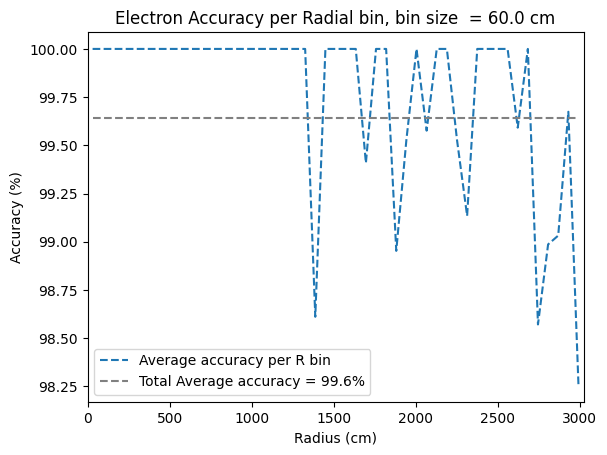

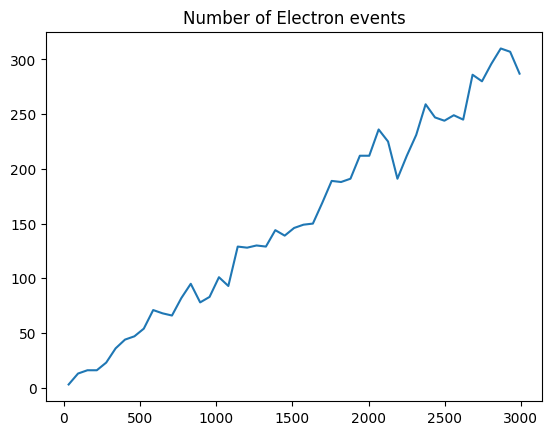

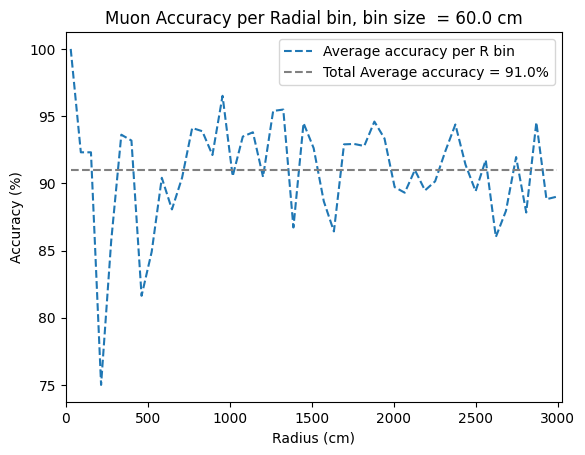

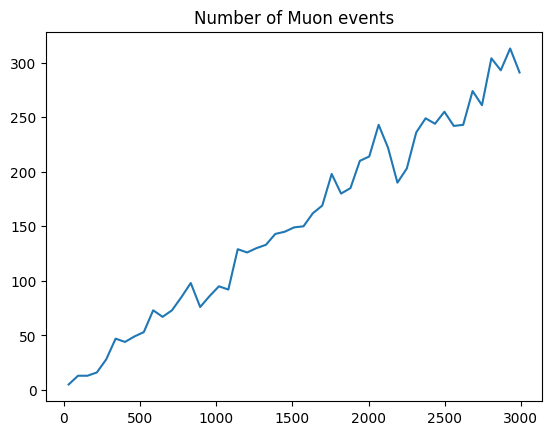

In [33]:
# Radial Accuracy for each particle

# Label = 0

def cartesian_to_cylindrical(x, y, z):
    """
    Convert Cartesian coordinates to cylindrical coordinates.
    x, y, z: numpy arrays of Cartesian coordinates.
    Returns: rho, phi, z (cylindrical coordinates).
    """
    rho = np.sqrt(x**2 + y**2)          # Radial distance
    phi = np.arctan2(y, x)             # Angle in rads
    return rho, phi, z 

targets_scaled = targets*mean_scale['targets']['scale'][:4].numpy()+mean_scale['targets']['mean'][:4].numpy()
recons_scaled = outputs_targets*mean_scale['targets']['scale'][:4].numpy()+mean_scale['targets']['mean'][:4].numpy()

x_recons, y_recons, z_recons = recons_scaled[:, 1], recons_scaled[:, 2], recons_scaled[:, 3]
x_target, y_target, z_target = targets_scaled[:, 1], targets_scaled[:, 2], targets_scaled[:, 3]

rho_recons, phi_recons, z_recons = cartesian_to_cylindrical(x_recons, y_recons, z_recons)
rho_target, phi_target, z_target = cartesian_to_cylindrical(x_target, y_target, z_target)

def particle_separator_radial(outputs_class, labels, rho_target, particle):
    
    bins = np.linspace(0, max(rho_target), 50)  


    bin_indices = np.digitize(rho_target, bins)


    split_radii = {i: [] for i in range(len(bins)-1)}
    split_out = {i: [] for i in range(len(bins)-1)}
    split_label = {i: [] for i in range(len(bins)-1)}


    for i, bin_idx in enumerate(bin_indices):
        if 0 < bin_idx < len(bins):  
            split_radii[bin_idx-1].append(rho_target[i])
            split_out[bin_idx-1].append(outputs_class[i, 1])
            split_label[bin_idx-1].append(labels[i])


    split_radii = {k: np.array(v) for k, v in split_radii.items()}
    split_out = {k: np.array(v) for k, v in split_out.items()}
    split_labels = {k: np.array(v) for k, v in split_label.items()}

    acc = accuracy_calc(torch.tensor(outputs_class[:, 1]), torch.tensor(labels))
    acc_split = []
    xplot = []
    ymean = []
    rnums = []
    for k in split_radii:
        acc_split.append(accuracy_calc(torch.tensor(split_out[k]), torch.tensor(split_labels[k]))*100)
        xplot.append((bins[k]+bins[k+1])/2)
        ymean.append(acc*100)
        rnums.append(len(split_radii[k]))
        #print(f"Accuracy in region R = {np.round(bins[k])} - {np.round(bins[k+1])}cm: {np.round(acc_split[k])}%")

    plt.plot(xplot, acc_split, linestyle = 'dashed', label = 'Average accuracy per R bin')
    plt.plot(xplot, ymean, linestyle = 'dashed', color = 'grey', label = 'Total Average accuracy = {:.1f}%'.format(acc*100))
    plt.xlim(0, max(rho_target))
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Radius (cm)")
    plt.legend()
    plt.title(f"{particle} Accuracy per Radial bin, bin size  = {np.round(max(rho_target)/50)} cm")
    plt.show()

    plt.plot(xplot, rnums)
    plt.title(f"Number of {particle} events")
    plt.show()

eoutputs_class = outputs_class[eevents]
elabels = labels[eevents]
erho_target = rho_target[eevents]
eparticle = 'Electron'

particle_separator_radial(eoutputs_class, elabels, erho_target, eparticle)

moutputs_class = outputs_class[mevents]
mlabels = labels[mevents]
mrho_target = rho_target[mevents]
mparticle = 'Muon'

particle_separator_radial(moutputs_class, mlabels, mrho_target, mparticle)


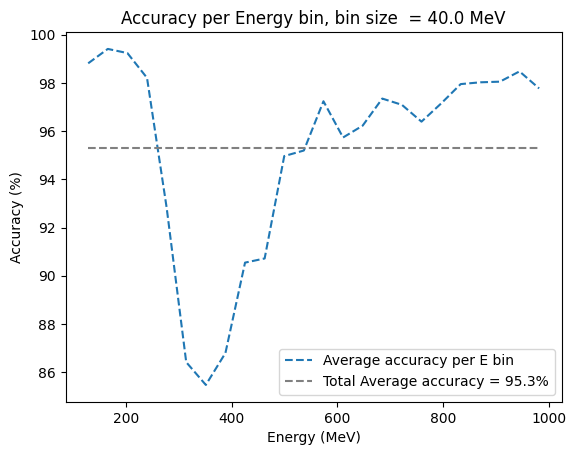

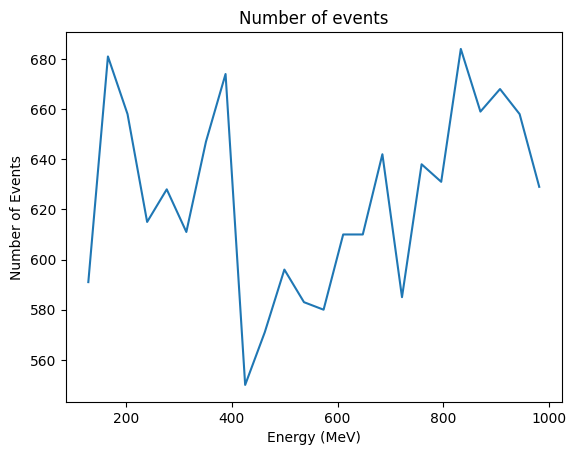

In [11]:
#PID Accuracy as a function of energy
bin_num = 25
bins = np.linspace(min(targets_scaled[:,0]), max(targets_scaled[:,0]), bin_num)  
energy = targets_scaled[:,0]

bin_indices = np.digitize(energy, bins)

split_energy = {i: [] for i in range(len(bins)-1)}
split_oute = {i: [] for i in range(len(bins)-1)}
split_labele = {i: [] for i in range(len(bins)-1)}


for i, bin_idx in enumerate(bin_indices):
    if 0 < bin_idx < len(bins):  
        split_energy[bin_idx-1].append(energy[i])
        split_oute[bin_idx-1].append(outputs_class[i, 1])
        split_labele[bin_idx-1].append(labels[i])


split_energy = {k: np.array(v) for k, v in split_energy.items()}
split_oute = {k: np.array(v) for k, v in split_oute.items()}
split_labelse = {k: np.array(v) for k, v in split_labele.items()}


acc_splite = []
xplote = []
ymeane = []
enums = []
for k in split_energy:
    acc_splite.append(accuracy_calc(torch.tensor(split_oute[k]), torch.tensor(split_labelse[k]))*100)
    xplote.append((bins[k]+bins[k+1])/2)
    ymeane.append(acc*100)
    enums.append(len(split_energy[k]))
    #print(f"Accuracy in region R = {np.round(bins[k])} - {np.round(bins[k+1])}cm: {np.round(acc_split[k])}%")

plt.plot(xplote, acc_splite, linestyle = 'dashed', label = 'Average accuracy per E bin')
plt.plot(xplote, ymeane, linestyle = 'dashed', color = 'grey', label = 'Total Average accuracy = {:.1f}%'.format(acc*100))
plt.ylabel("Accuracy (%)")
plt.xlabel("Energy (MeV)")
plt.legend()
plt.title(f"Accuracy per Energy bin, bin size  = {np.round(max(energy)/bin_num)} MeV")
plt.show()

plt.plot(xplote, enums)
plt.title("Number of events")
plt.xlabel("Energy (MeV)")
plt.ylabel("Number of Events")
plt.show()


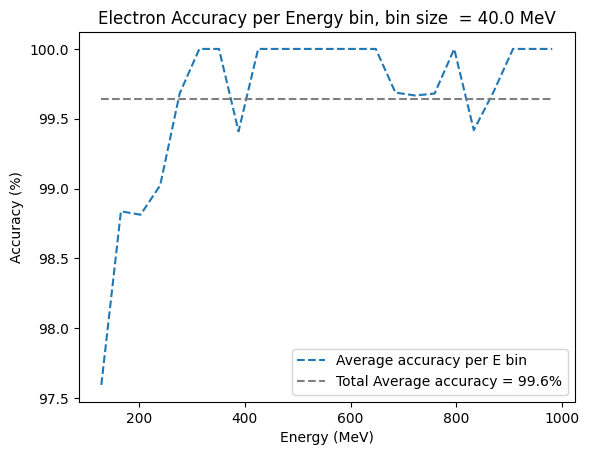

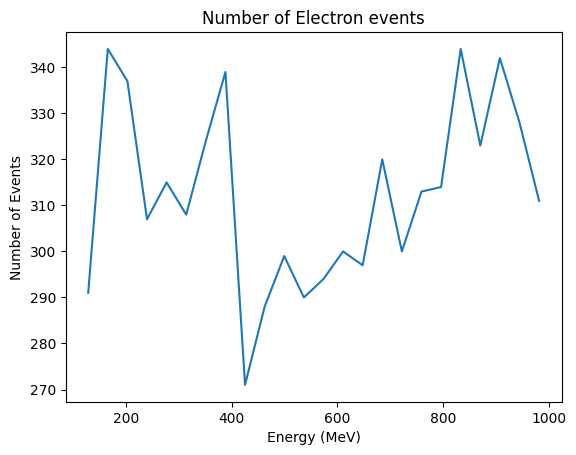

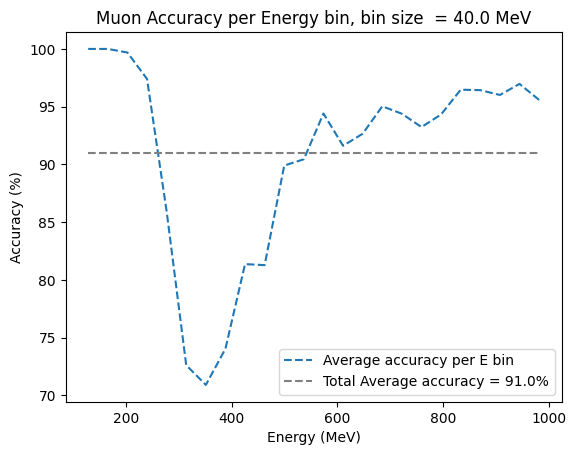

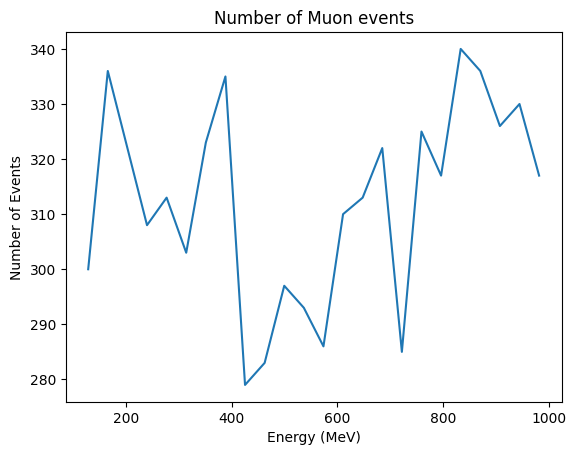

In [12]:
# PID per particle type as function of energy

def particle_separator_energy(targets_scaled, outputs_class, labels, particle):
    #PID Accuracy as a function of energy
    bin_num = 25
    bins = np.linspace(min(targets_scaled[:,0]), max(targets_scaled[:,0]), bin_num)  
    energy = targets_scaled[:,0]

    bin_indices = np.digitize(energy, bins)

    split_energy = {i: [] for i in range(len(bins)-1)}
    split_oute = {i: [] for i in range(len(bins)-1)}
    split_labele = {i: [] for i in range(len(bins)-1)}


    for i, bin_idx in enumerate(bin_indices):
        if 0 < bin_idx < len(bins):  
            split_energy[bin_idx-1].append(energy[i])
            split_oute[bin_idx-1].append(outputs_class[i, 1])
            split_labele[bin_idx-1].append(labels[i])


    split_energy = {k: np.array(v) for k, v in split_energy.items()}
    split_oute = {k: np.array(v) for k, v in split_oute.items()}
    split_labelse = {k: np.array(v) for k, v in split_labele.items()}
    acc = accuracy_calc(torch.tensor(outputs_class[:, 1]), torch.tensor(labels))

    acc_splite = []
    xplote = []
    ymeane = []
    enums = []
    for k in split_energy:
        acc_splite.append(accuracy_calc(torch.tensor(split_oute[k]), torch.tensor(split_labelse[k]))*100)
        xplote.append((bins[k]+bins[k+1])/2)
        ymeane.append(acc*100)
        enums.append(len(split_energy[k]))
        #print(f"Accuracy in region R = {np.round(bins[k])} - {np.round(bins[k+1])}cm: {np.round(acc_split[k])}%")

    plt.plot(xplote, acc_splite, linestyle = 'dashed', label = 'Average accuracy per E bin')
    plt.plot(xplote, ymeane, linestyle = 'dashed', color = 'grey', label = 'Total Average accuracy = {:.1f}%'.format(acc*100))
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Energy (MeV)")
    plt.legend()
    plt.title(f"{particle} Accuracy per Energy bin, bin size  = {np.round(max(energy)/bin_num)} MeV")
    plt.show()

    plt.plot(xplote, enums)
    plt.title(f"Number of {particle} events")
    plt.xlabel("Energy (MeV)")
    plt.ylabel("Number of Events")
    plt.show()

etargets_scaled = targets_scaled[eevents]
eoutputs_class = outputs_class[eevents]
elabels = labels[eevents]
eparticle = 'Electron'

mtargets_scaled = targets_scaled[mevents]
moutputs_class = outputs_class[mevents]
mlabels = labels[mevents]
mparticle = 'Muon'

particle_separator_energy(etargets_scaled, eoutputs_class, elabels, eparticle)
particle_separator_energy(mtargets_scaled, moutputs_class, mlabels, mparticle)



<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

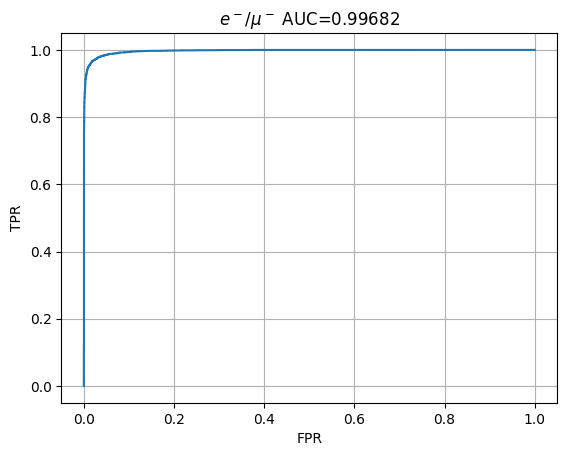

In [13]:
title=r'$e^-/\mu^-$ AUC={:.5f}'.format(auc)
plt.title(title)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.ylabel

In [14]:
### MSE ###
import torch.nn.functional as F
print('MSE')
variables=['Energy', 'Position:X', 'Position:Y', 'Position:Z']
for i in range(4):
    print('{:s} {:.4f}'.format(variables[i], float(F.mse_loss(torch.tensor(targets[:,i]), torch.tensor(outputs_targets[:,i])))))

MSE
Energy 0.0066
Position:X 0.0018
Position:Y 0.0019
Position:Z 0.0018


### Comparison of the outputs and the normalised variables ###

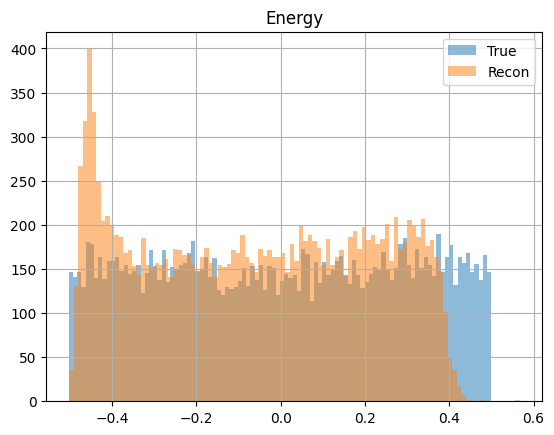

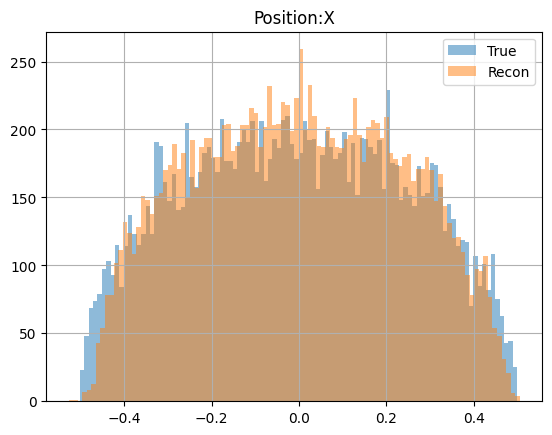

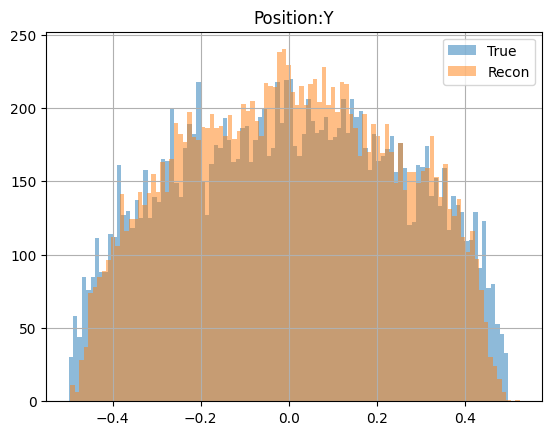

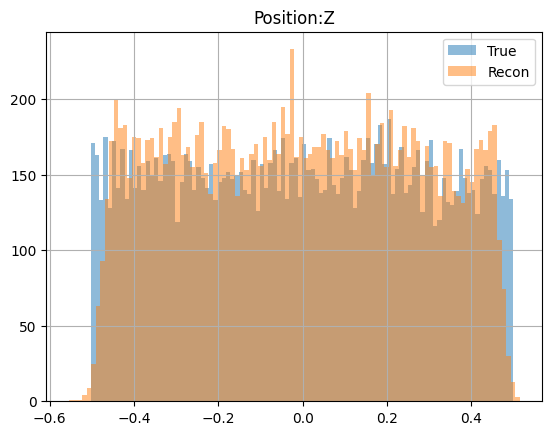

In [15]:
titles = ['Energy', 'Position:X', 'Position:Y', 'Position:Z']
for i in range(len(titles)):
    plt.title(titles[i])
    plt.hist(targets[:,i], bins=100, alpha=0.5, label='True')
    plt.hist(outputs_targets[:,i], bins=100, alpha=0.5, label='Recon')
    plt.grid()
    plt.legend()
    plt.show()


#### Scale to orgiginal ####

In [16]:
targets_scaled = targets*mean_scale['targets']['scale'][:4].numpy()+mean_scale['targets']['mean'][:4].numpy()
recons_scaled = outputs_targets*mean_scale['targets']['scale'][:4].numpy()+mean_scale['targets']['mean'][:4].numpy()

In [17]:
## rectangular coordinate to spherical coordinate
def rec2sph(rec):
    print(rec[2].shape)
    r=np.linalg.norm(rec,ord=2,axis=0)
    print(r.shape)
    theta=np.arccos(rec[2]/r)
    rho=np.linalg.norm(rec[:2], ord=2, axis=0)
    phi=np.arccos(rec[0]/rho)
    #phi=phi*-1 if rec[1]<0 else phi
    phi=np.where(rec[1]<0, phi, phi*-1)
    #return np.array([r,theta,phi])
    return r,theta,phi

# Rectangular to Cylindrical

def rec2cyl(rec):
    rho = np.linalg.norm(rec[:2], axis=0)  # Radial distance (x^2 + y^2)^0.5
    phi = np.arctan2(rec[1], rec[0])       # Angle in radians
    z = rec[2]  
    return rho, z, phi

    



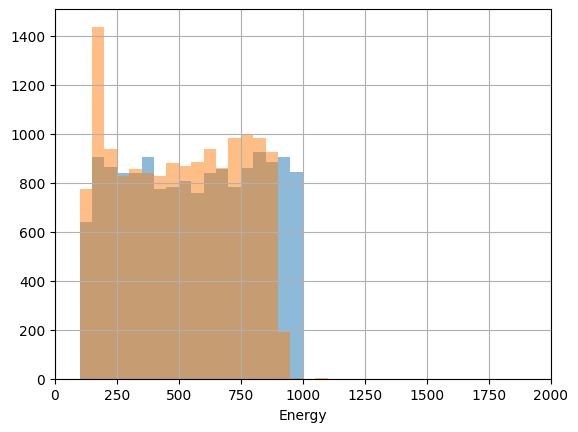

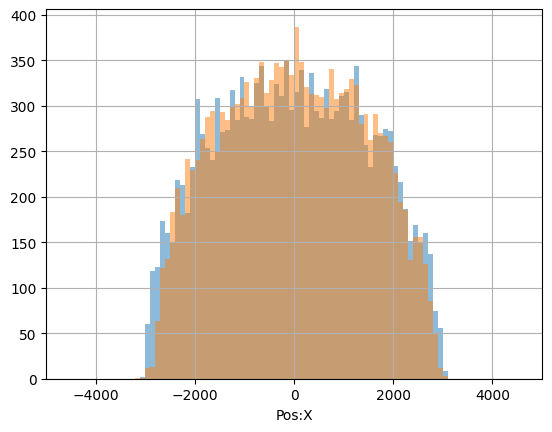

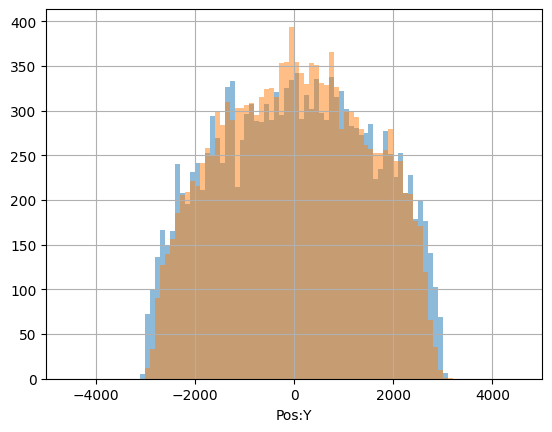

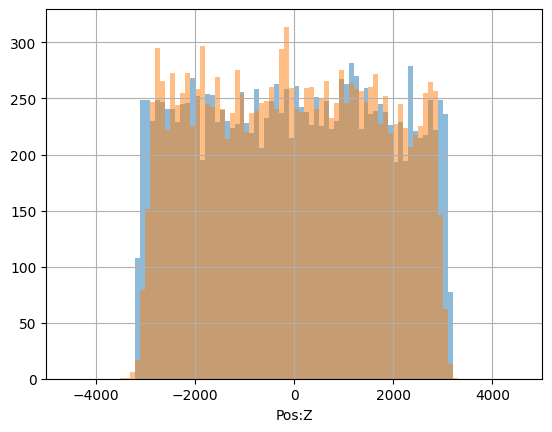

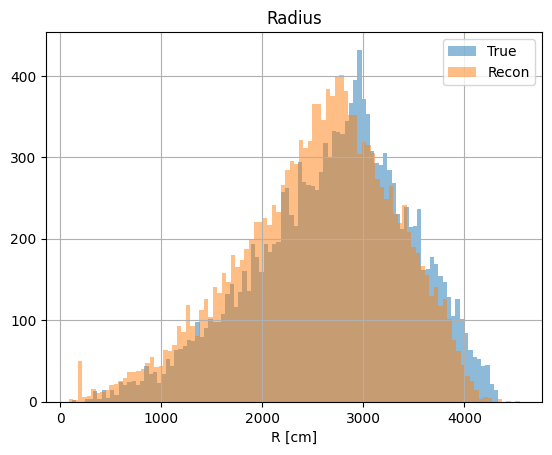

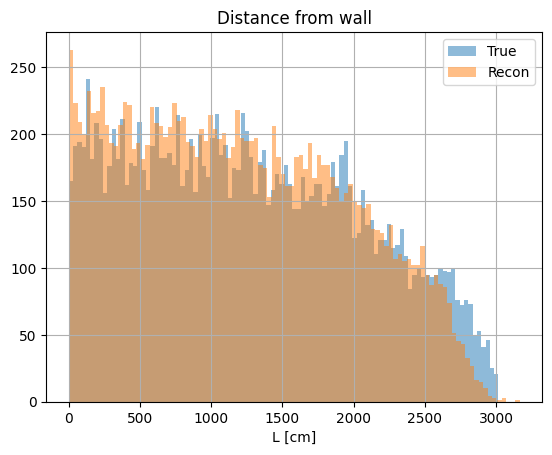

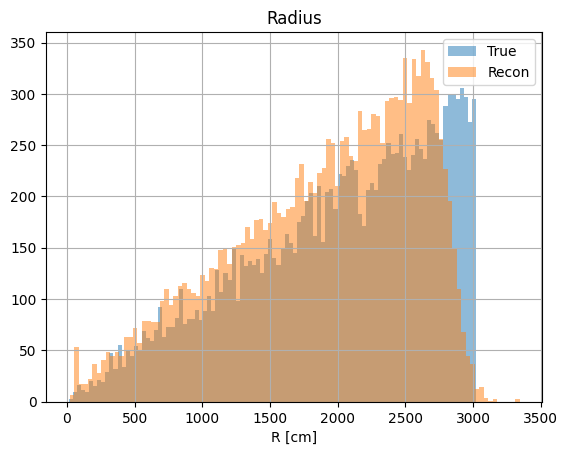

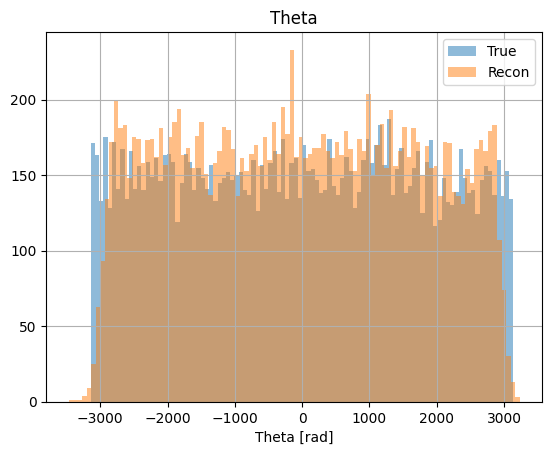

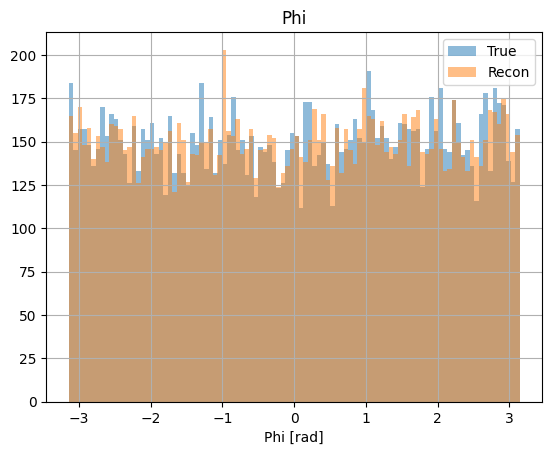

(15000,)


In [18]:
targets

variables = ['Energy', 'Pos:X', 'Pos:Y', 'Pos:Z']
bin_widths={'Type':1, 'Energy':50, 'Pos:X':100, 'Pos:Y':100, 'Pos:Z':100, 'Dir:Theta':np.pi/18, 'Dir:Phi':np.pi/18}
ranges = {'Type':[-1,2], 'Energy':[0,2000], 'Pos:X':[-5000,5000], 'Pos:Y':[-5000,5000], 'Pos:Z':[-5000,5000], 'Dir:Theta':[-np.pi,np.pi*2], 'Dir:Phi':[-np.pi*2, np.pi*2]} 
for i in range(len(variables)):
    variable=variables[i]

    bins=int((ranges[variable][1]-ranges[variable][0])/bin_widths[variable])
    plt.hist(targets_scaled[:,i], bins=bins, range=ranges[variable], alpha=0.5, label='True')
    plt.hist(recons_scaled[:,i], bins=bins, range=ranges[variable], alpha=0.5, label='Recon')
    plt.xlabel(variable)
    #plt.ylabel('Recon - True')
    #plt.ylim([-500,500])
    plt.xlim([ranges[variable][0],ranges[variable][1]])
    plt.grid()
    plt.show()


    if variable=='Pos:Z':
        r_true=np.linalg.norm(targets_scaled[:,1:], ord=2, axis=1)
        r_recon=np.linalg.norm(recons_scaled[:,1:], ord=2, axis=1)
        plt.title('Radius')
        plt.hist(r_true, bins=100, alpha=0.5, label='True')
        plt.hist(r_recon, bins=100, alpha=0.5, label='Recon')
        plt.xlabel('R [cm]')
        plt.grid()
        plt.legend()
        plt.show()

        l_true=np.linalg.norm(targets_scaled[:,1:2], ord=2, axis=1)
        l_recon=np.linalg.norm(recons_scaled[:,1:2], ord=2, axis=1)
        plt.title('Distance from wall')
        plt.hist(l_true, bins=100, alpha=0.5, label='True')
        plt.hist(l_recon, bins=100, alpha=0.5, label='Recon')
        plt.xlabel('L [cm]')
        plt.grid()
        plt.legend()
        plt.show()

        rec_true = [targets_scaled[:,1], targets_scaled[:,2], targets_scaled[:,3]] 
        posR_true,posz_true,posPhi_true = rec2cyl(rec_true)
        rec_recon = [recons_scaled[:,1], recons_scaled[:,2], recons_scaled[:,3]] 
        posR_recon,posz_recon,posPhi_recon = rec2cyl(rec_recon)


        plt.title('Radius')
        plt.hist(posR_true, bins=100, alpha=0.5, label='True')
        plt.hist(posR_recon, bins=100, alpha=0.5, label='Recon')
        plt.xlabel('R [cm]')
        plt.grid()
        plt.legend()
        plt.show()

        plt.title('Theta')
        plt.hist(posz_true, bins=100, alpha=0.5, label='True')
        plt.hist(posz_recon, bins=100, alpha=0.5, label='Recon')
        plt.xlabel('Theta [rad]')
        plt.grid()
        plt.legend()
        plt.show()

        plt.title('Phi')
        plt.hist(posPhi_true, bins=100, alpha=0.5, label='True')
        plt.hist(posPhi_recon, bins=100, alpha=0.5, label='Recon')
        plt.xlabel('Phi [rad]')
        plt.grid()
        plt.legend()
        plt.show()

print(rec_true[2].shape)

### Functions ###

In [19]:
# function to check energy, position dependency
def binning(target, x, bin_width, bin_range):
    bins = int((bin_range[1]-bin_range[0])/bin_width)
    binned = []
    for i in range(bins):
        binned.append(x[((target>=(bin_range[0]+i*bin_width))&(target<(bin_range[0]+(i+1)*bin_width)))])

    return binned

In [20]:
def gaussian(x, amp, loc, sig):
    return amp*np.exp(-np.power(x - loc, 2.) / (2 * np.power(sig, 2.)))

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1213193/4138810147.py:20: SyntaxWarning: invalid escape sequence '\s'
  label='$\sigma$={:.1f}%'.format(p[2])
/tmp/ipykernel_1213193/4138810147.py:22: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E (%)')


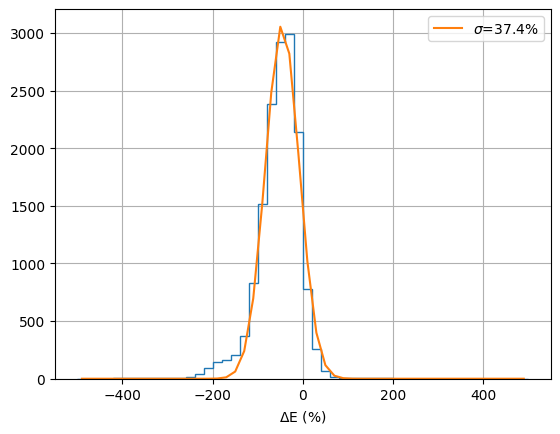

In [21]:
def binning(target, x, bin_width, bin_range):
    bins = int((bin_range[1]-bin_range[0])/bin_width)
    binned = []
    for i in range(bins):
        binned.append(x[((target>=(bin_range[0]+i*bin_width))&(target<(bin_range[0]+(i+1)*bin_width)))])

    return binned

erecon = recons_scaled[:,0]
etarget = targets_scaled[:,0]

ediff = erecon-etarget

hist_delE=plt.hist(ediff, bins=50, range=[-500,500], histtype='step', lw=2, density=False)
x_hist_delE = (hist_delE[1][1:]+hist_delE[1][0:-1])/2.
y_hist_delE = hist_delE[0]
p0 = [y_hist_delE.max(), ediff.mean(), ediff.std()]
p, pcov = curve_fit(gaussian, x_hist_delE, y_hist_delE, p0=p0)
fit=gaussian(x_hist_delE, p[0], p[1], p[2])
label='$\sigma$={:.1f}%'.format(p[2])
plt.plot(x_hist_delE, fit, label=label)
plt.xlabel('$\Delta$E (%)')
plt.legend()
plt.grid()
plt.show()

### Energy resolution ###
* Energy resolution depends on the energy

<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:43: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1213193/2644550341.py:31: SyntaxWarning: invalid escape sequence '\s'
  label='$\sigma$={:.1f}%'.format(p[2])
/tmp/ipykernel_1213193/2644550341.py:34: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E%')
/tmp/ipykernel_1213193/2644550341.py:43: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_{E}$ %')


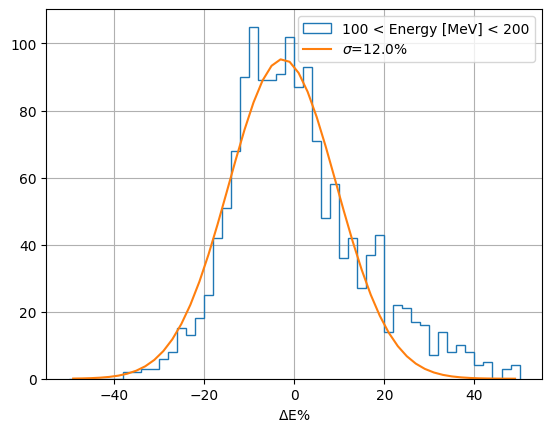

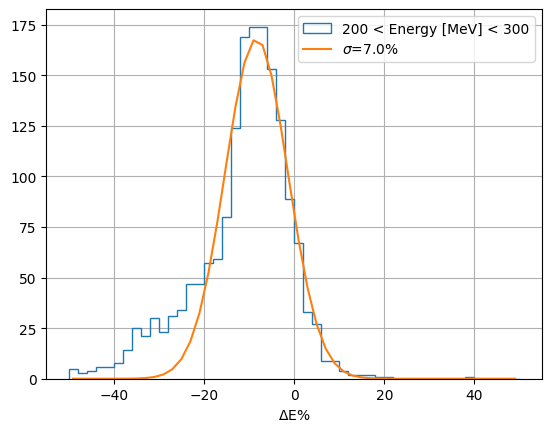

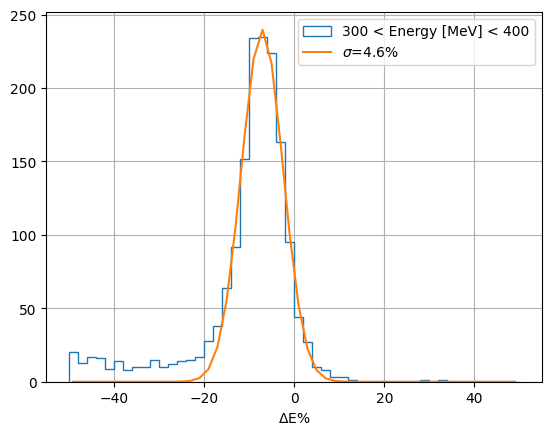

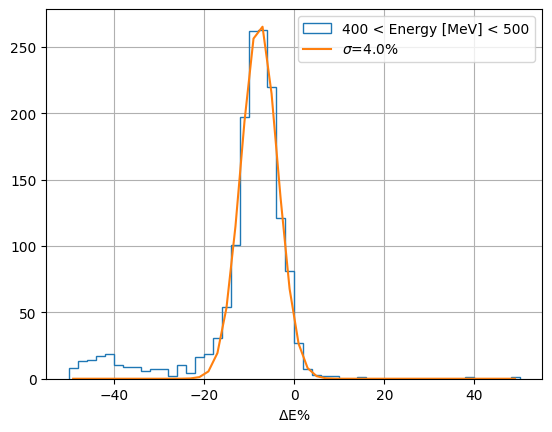

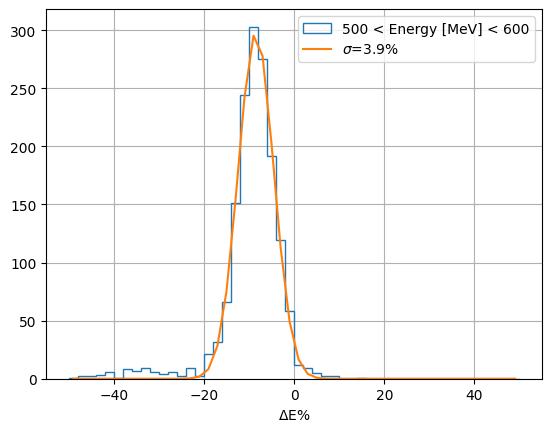

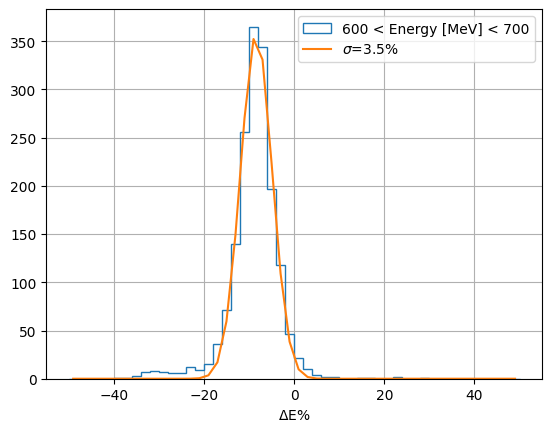

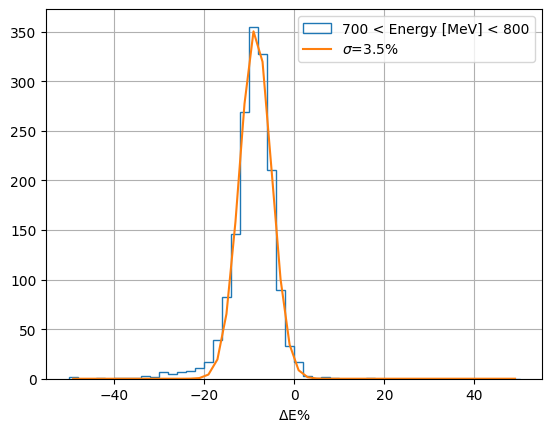

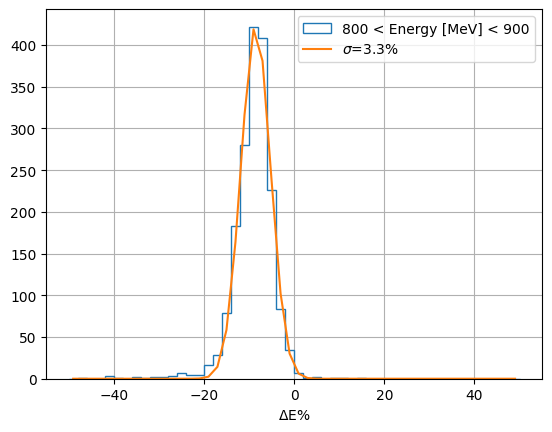

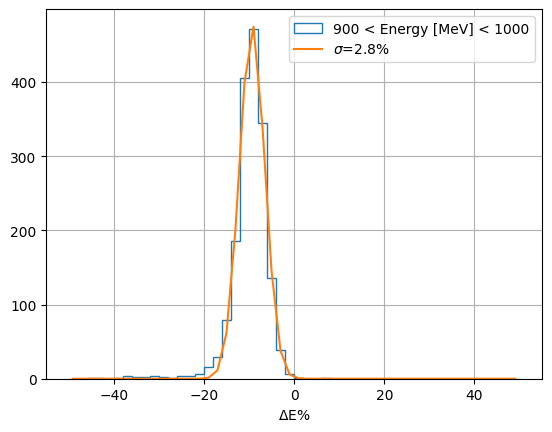

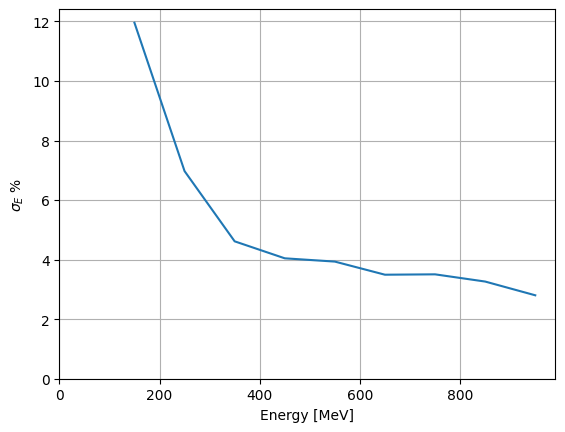

In [22]:
def binning(target, x, bin_width, bin_range):
    bins = int((bin_range[1]-bin_range[0])/bin_width)
    binned = []
    for i in range(bins):
        binned.append(x[((target>=(bin_range[0]+i*bin_width))&(target<(bin_range[0]+(i+1)*bin_width)))])

    return binned

bias=(recons_scaled-targets_scaled)/targets_scaled * 100. # %
# Energy resolution
#delE=difference[:,1]
delE=bias[:,0]

energy_range=[100,1000]
bin_width=100
delE_binned=binning(targets_scaled[:,0], delE, bin_width=bin_width, bin_range=energy_range)

sigma_E=[]
E=[]
for i in range(len(delE_binned)):
    lower=energy_range[0]+bin_width*i
    higher=energy_range[0]+bin_width*(i+1)
    E.append(lower+(higher-lower)/2.)
    label='{:d} < Energy [MeV] < {:d}'.format(lower,higher)
    hist_delE=plt.hist(delE_binned[i], bins=50, range=[-50,50], label=label , histtype='step', lw=2, density=False)
    x_hist_delE = (hist_delE[1][1:]+hist_delE[1][0:-1])/2.
    y_hist_delE = hist_delE[0]
    p0 = [y_hist_delE.max(), delE.mean(), delE.std()]
    p, pcov = curve_fit(gaussian, x_hist_delE, y_hist_delE, p0=p0)
    fit=gaussian(x_hist_delE, p[0], p[1], p[2])
    label='$\sigma$={:.1f}%'.format(p[2])
    sigma_E.append(p[2])
    plt.plot(x_hist_delE, fit, label=label)
    plt.xlabel('$\Delta$E%')
    plt.legend()
    plt.grid()
    plt.show()

plt.plot(E,sigma_E)
plt.xlim([0.,None])
plt.ylim([0.,None])
plt.xlabel('Energy [MeV]')
plt.ylabel('$\sigma_{E}$ %')
plt.grid()
plt.show()



<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:49: SyntaxWarning: invalid escape sequence '\s'
<>:77: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:49: SyntaxWarning: invalid escape sequence '\s'
<>:77: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1213193/2490975306.py:35: SyntaxWarning: invalid escape sequence '\s'
  label='$\sigma$={:.1f} %'.format(p[2])
/tmp/ipykernel_1213193/2490975306.py:39: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E [%]')
/tmp/ipykernel_1213193/2490975306.py:49: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_{E}$ [%]')
/tmp/ipykernel_1213193/2490975306.py:77: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma$ [%]')


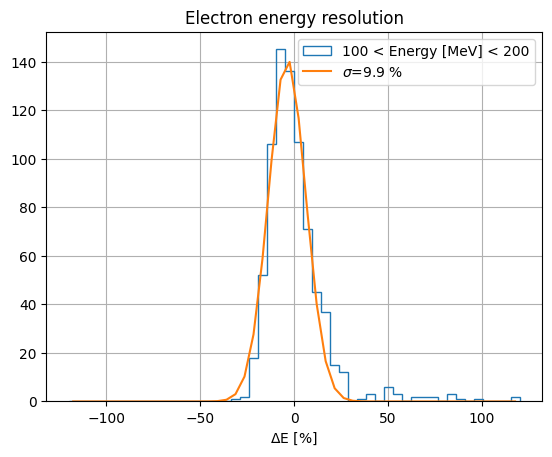

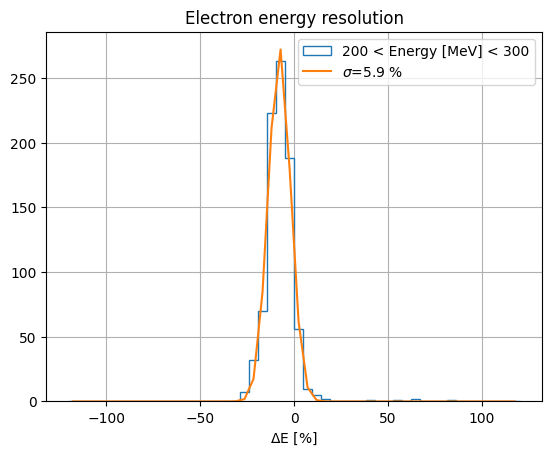

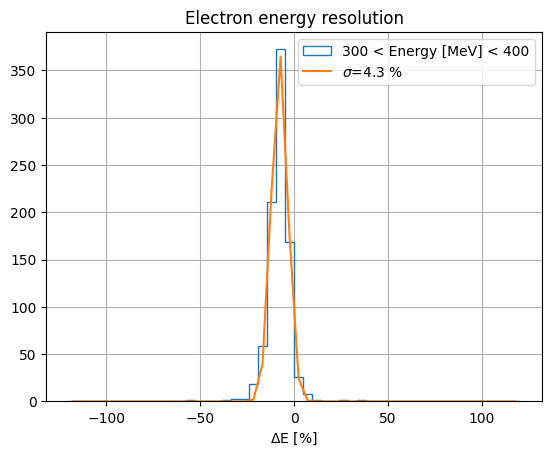

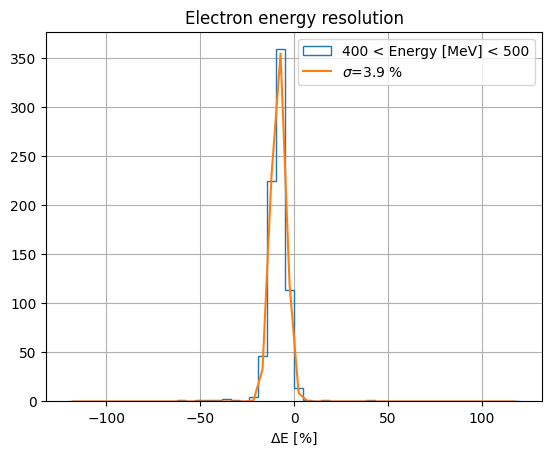

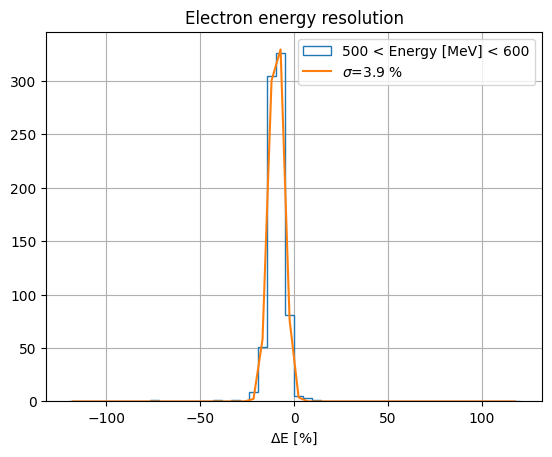

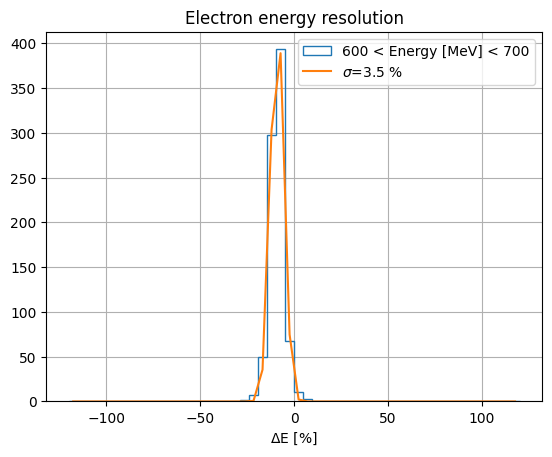

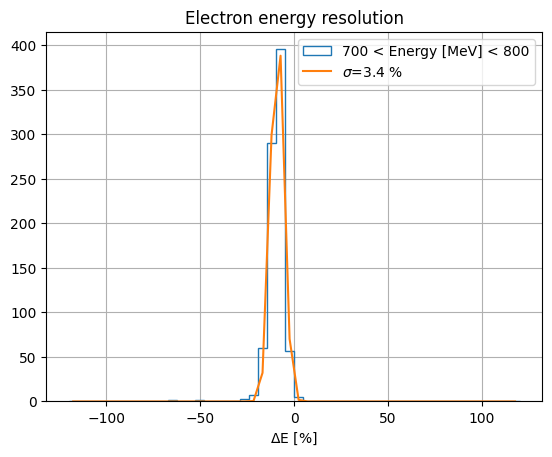

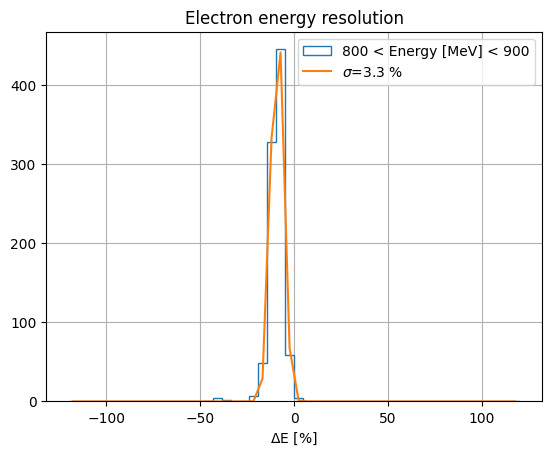

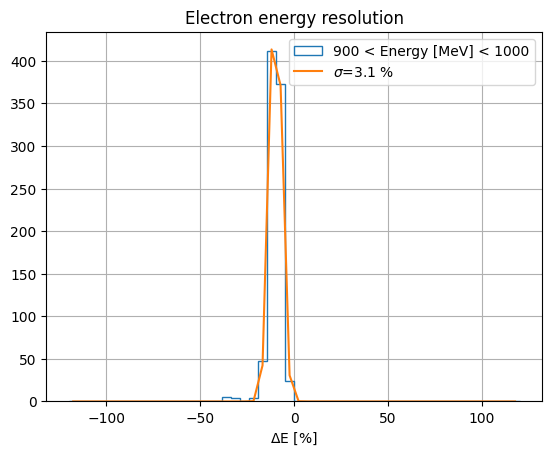

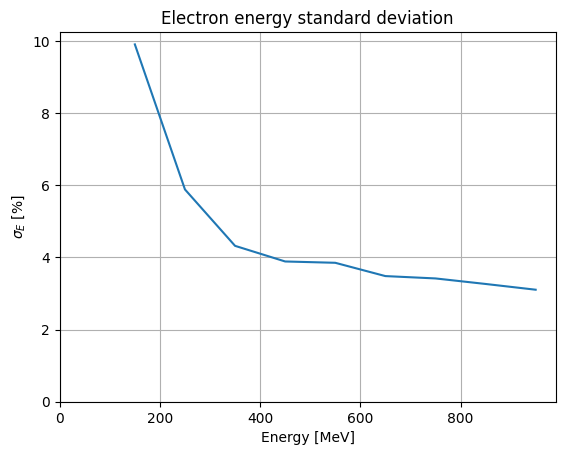

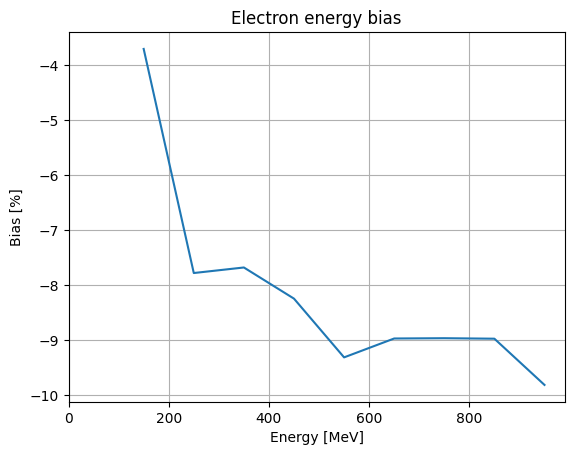

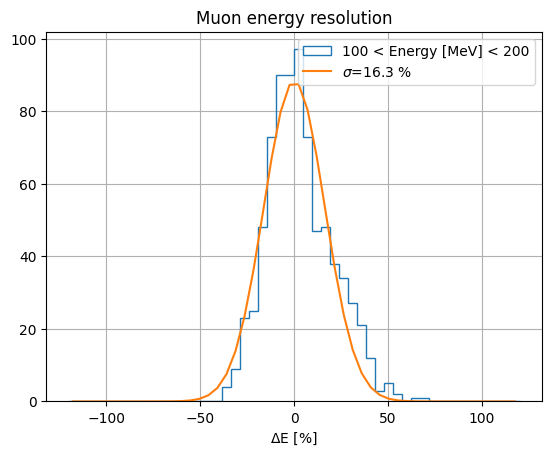

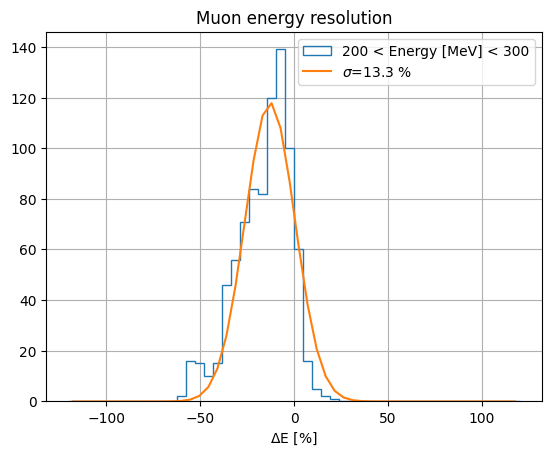

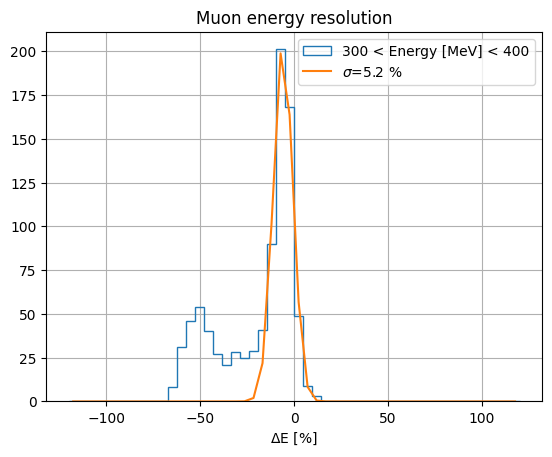

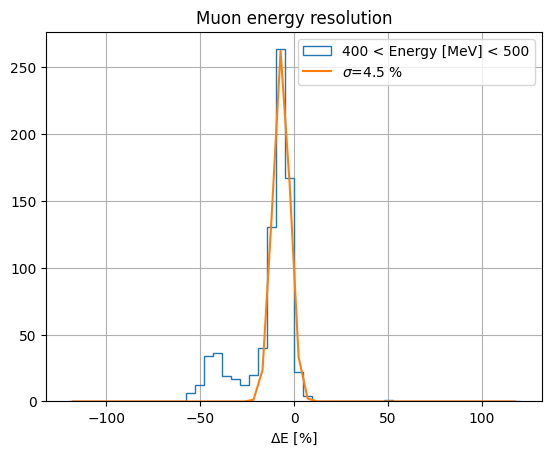

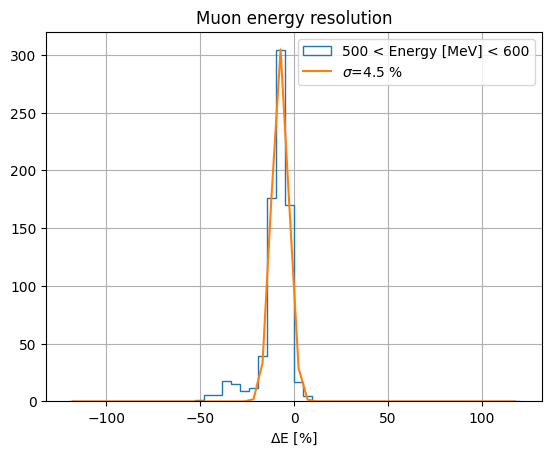

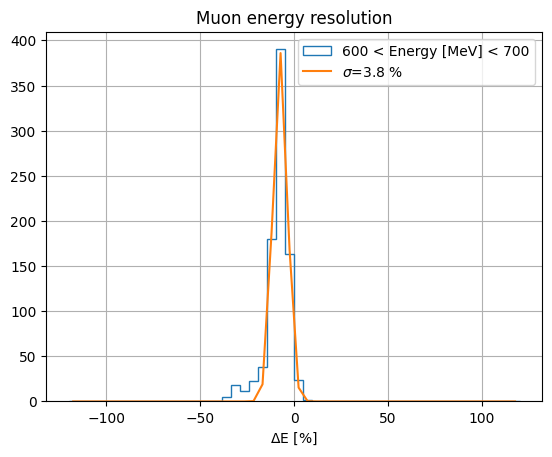

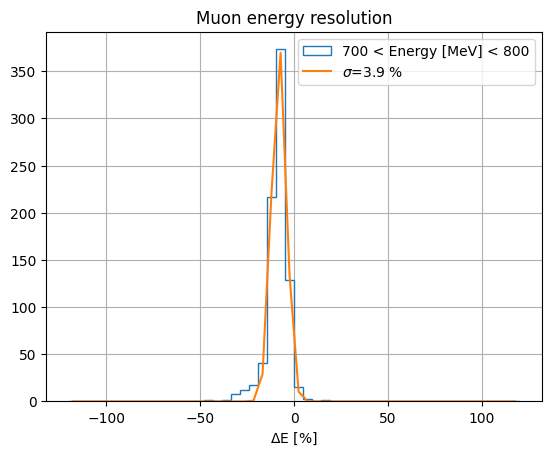

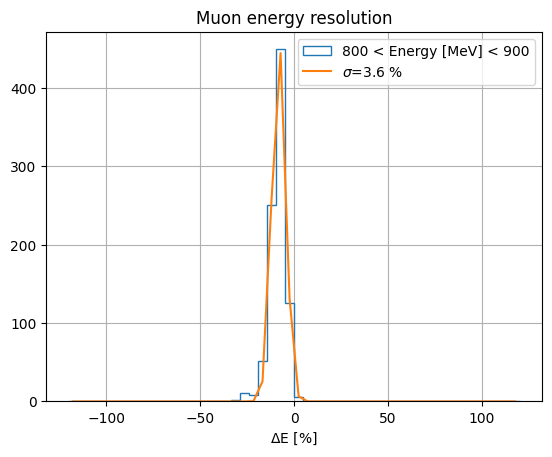

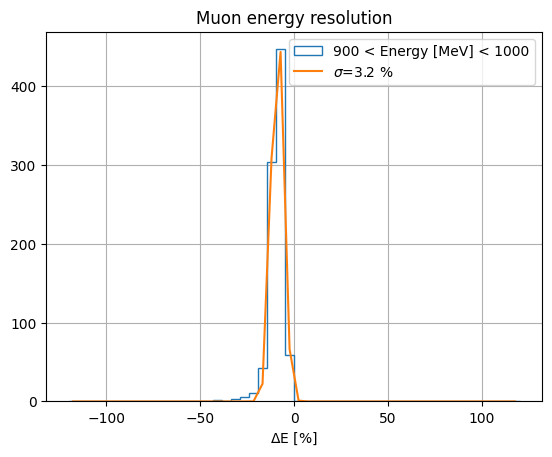

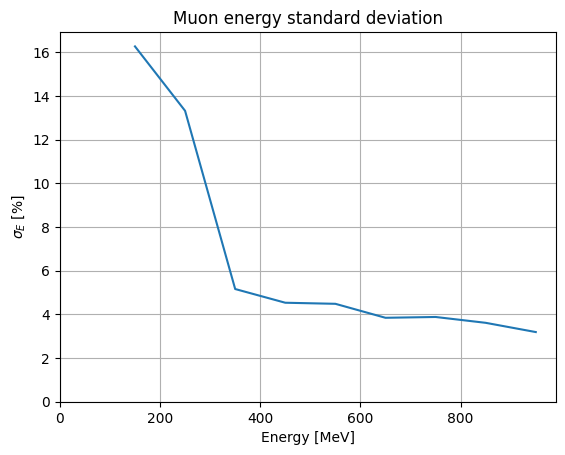

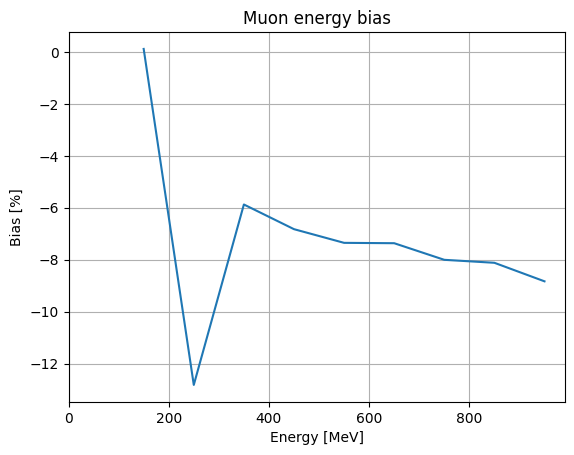

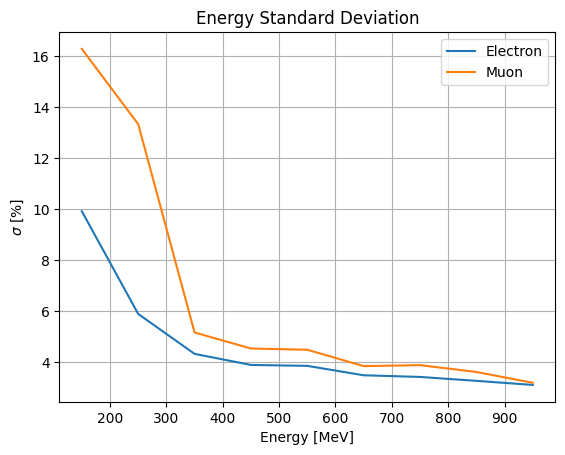

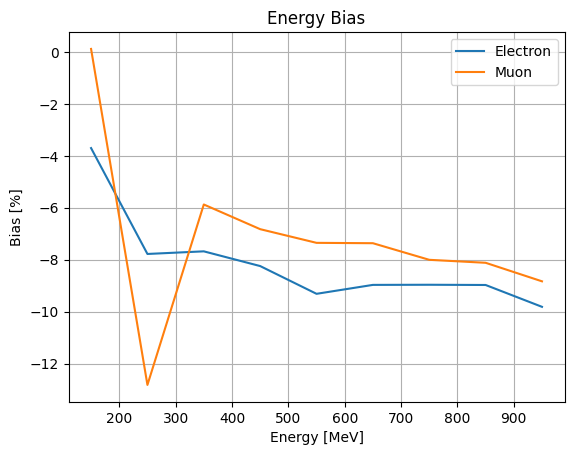

In [23]:
# Energy resolution per particle 

def particle_separator_energy_res(recons_scaled, targets_scaled, particle):
    def binning(target, x, bin_width, bin_range):
        bins = int((bin_range[1]-bin_range[0])/bin_width)
        binned = []
        for i in range(bins):
            binned.append(x[((target>=(bin_range[0]+i*bin_width))&(target<(bin_range[0]+(i+1)*bin_width)))])

        return binned

    bias=(recons_scaled-targets_scaled)/targets_scaled * 100. # %
    # Energy resolution
    #delE=difference[:,1]
    delE=bias[:,0]

    energy_range=[100,1000]
    bin_width=100
    delE_binned=binning(targets_scaled[:,0], delE, bin_width=bin_width, bin_range=energy_range)

    sigma_E=[]
    biasE = []
    E=[]
    for i in range(len(delE_binned)):
        lower=energy_range[0]+bin_width*i
        higher=energy_range[0]+bin_width*(i+1)
        E.append(lower+(higher-lower)/2.)
        label='{:d} < Energy [MeV] < {:d}'.format(lower,higher)
        hist_delE=plt.hist(delE_binned[i], bins=50, range=[-120,120], label=label , histtype='step', lw=2, density=False)
        x_hist_delE = (hist_delE[1][1:]+hist_delE[1][0:-1])/2.
        y_hist_delE = hist_delE[0]
        p0 = [y_hist_delE.max(), delE.mean(), delE.std()]
        p, pcov = curve_fit(gaussian, x_hist_delE, y_hist_delE, p0=p0)
        fit=gaussian(x_hist_delE, p[0], p[1], p[2])
        label='$\sigma$={:.1f} %'.format(p[2])
        sigma_E.append(p[2])
        biasE.append(p[1])
        plt.plot(x_hist_delE, fit, label=label)
        plt.xlabel('$\Delta$E [%]')
        plt.legend()
        plt.title(f'{particle} energy resolution')
        plt.grid()
        plt.show()

    plt.plot(E,sigma_E)
    plt.xlim([0.,None])
    plt.ylim([0.,None])
    plt.xlabel('Energy [MeV]')
    plt.ylabel('$\sigma_{E}$ [%]')
    plt.title(f'{particle} energy standard deviation')
    plt.grid()
    plt.show()

    plt.plot(E, biasE)
    plt.xlim([0., None])
    plt.xlabel('Energy [MeV]')
    plt.ylabel('Bias [%]')
    plt.title(f'{particle} energy bias')
    plt.grid()
    plt.show()
    return sigma_E, biasE, E

erecons_scaled = recons_scaled[eevents]
etargets_scaled = targets_scaled[eevents]
eparticle = "Electron"

mrecons_scaled = recons_scaled[mevents]
mtargets_scaled = targets_scaled[mevents]
mparticle = 'Muon'

electron_sigma, electron_bias, e_energy_range = particle_separator_energy_res(erecons_scaled, etargets_scaled, eparticle)
muon_sigma, muon_bias, m_energy_range = particle_separator_energy_res(mrecons_scaled, mtargets_scaled, mparticle)

plt.plot(e_energy_range, electron_sigma, label = 'Electron')
plt.plot(e_energy_range, muon_sigma, label = 'Muon')
plt.xlabel('Energy [MeV]')
plt.ylabel('$\sigma$ [%]')
plt.legend()
plt.title('Energy Standard Deviation')
plt.grid()
plt.show()

plt.plot(e_energy_range, electron_bias, label = 'Electron')
plt.plot(e_energy_range, muon_bias, label = 'Muon')
plt.xlabel('Energy [MeV]')
plt.ylabel('Bias [%]')
plt.legend()
plt.title('Energy Bias')
plt.grid()
plt.show()


### Vertex resolution ###
* The resolution is calculated by np.std(). Try to calculate by fitting with gaussian.
* The resolution depends on the position.

6.268197


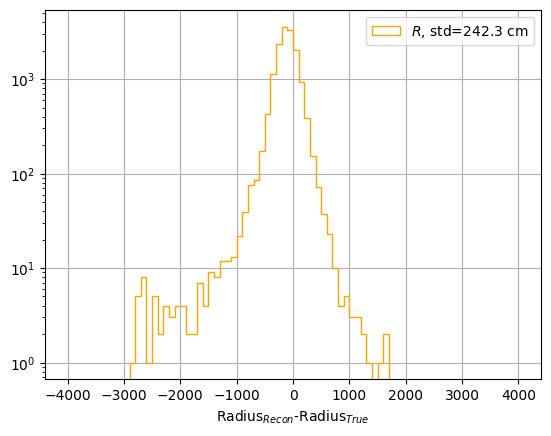

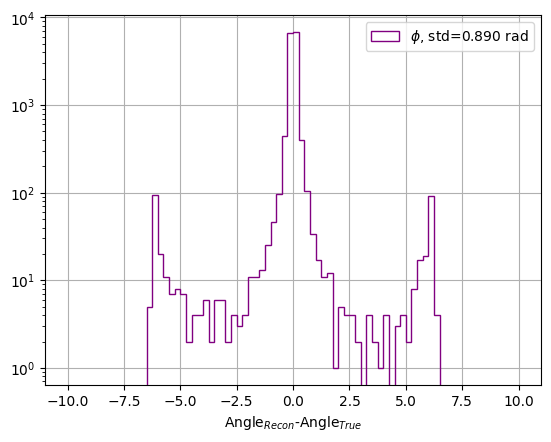

-6.281891


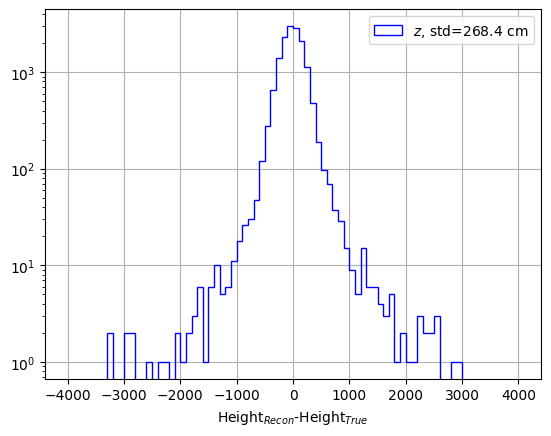

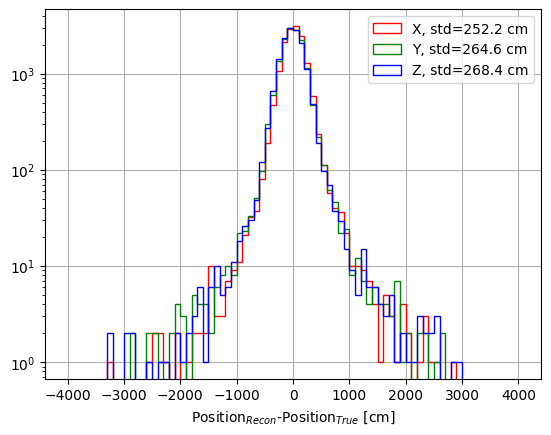

In [24]:
def cartesian_to_cylindrical(x, y, z):
    """
    Convert Cartesian coordinates to cylindrical coordinates.
    x, y, z: numpy arrays of Cartesian coordinates.
    Returns: rho, phi, z (cylindrical coordinates).
    """
    rho = np.sqrt(x**2 + y**2)          # Radial distance
    phi = np.arctan2(y, x)             # Angle in rads
    return rho, phi, z                  

# Extract Cartesian coordinates from the scaled arrays
x_recons, y_recons, z_recons = recons_scaled[:, 1], recons_scaled[:, 2], recons_scaled[:, 3]
x_target, y_target, z_target = targets_scaled[:, 1], targets_scaled[:, 2], targets_scaled[:, 3]

# Convert to cylindrical coordinates
rho_recons, phi_recons, z_recons = cartesian_to_cylindrical(x_recons, y_recons, z_recons)
rho_target, phi_target, z_target = cartesian_to_cylindrical(x_target, y_target, z_target)

# Compute differences in cylindrical coordinates
distance_rho = rho_recons - rho_target
distance_phi = phi_recons - phi_target
distance_z = z_recons - z_target
distance_phi = distance_phi
print(max(distance_phi))
# Plot histograms
plt.hist(distance_rho, bins=80, range=[-4000, 4000], label=r'$R$, std={:.1f} cm'.format(distance_rho.std()), color='orange', histtype='step', lw=2)
plt.yscale('log')
plt.xlabel(r'Radius$_{Recon}$-Radius$_{True}$')
plt.legend()
plt.grid()
plt.show()
plt.hist(distance_phi, bins=80, range=[-10, 10], label=r'$\phi$, std={:.3f} rad'.format(distance_phi.std()), color='purple', histtype='step', lw=2)
plt.yscale('log')
plt.xlabel(r'Angle$_{Recon}$-Angle$_{True}$')
plt.legend()
plt.grid()
plt.show()
plt.hist(distance_z, bins=80, range=[-4000, 4000], label=r'$z$, std={:.1f} cm'.format(distance_z.std()), color='blue', histtype='step', lw=2)
print(min(distance_phi))
plt.yscale('log')
plt.xlabel(r'Height$_{Recon}$-Height$_{True}$')
plt.legend()
plt.grid()
plt.show()

distance = recons_scaled[:,1:]-targets_scaled[:,1:]

plt.hist(distance[:,0], bins=80, range=[-4000,4000], label='X, std={:.1f} cm'.format(distance.std(axis=0)[0]), color='red', histtype='step', lw=2)
plt.hist(distance[:,1], bins=80, range=[-4000,4000], label='Y, std={:.1f} cm'.format(distance.std(axis=0)[1]), color='green', histtype='step', lw=2)
plt.hist(distance[:,2], bins=80, range=[-4000,4000], label='Z, std={:.1f} cm'.format(distance.std(axis=0)[2]), color='blue', histtype='step', lw=2)
plt.yscale('log')
plt.xlabel(r'Position$_{Recon}$-Position$_{True}$ [cm]')
plt.legend()
plt.grid()
plt.show()

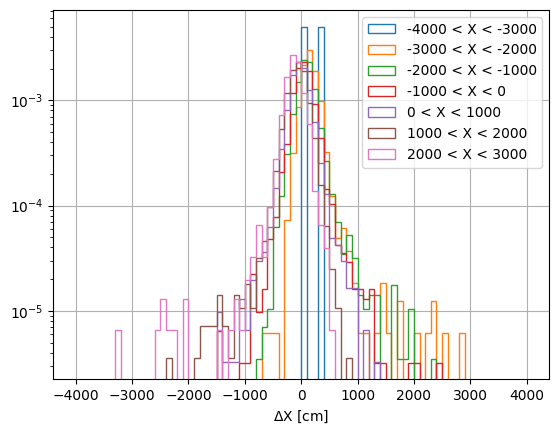

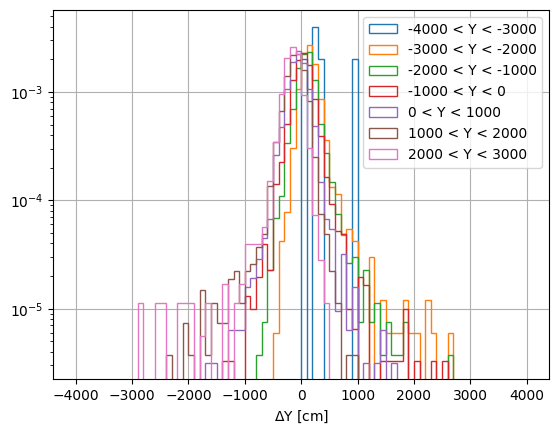

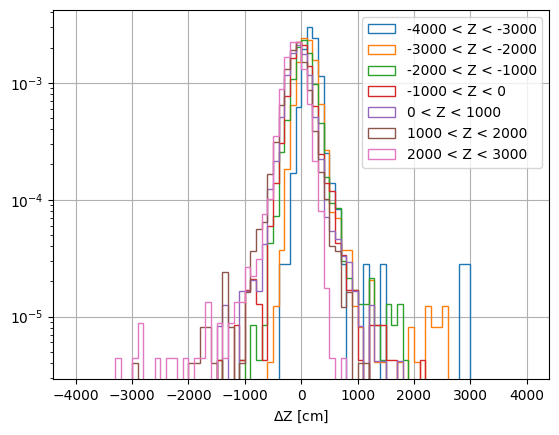

In [25]:
distance_x_binned=binning(targets_scaled[:,1], distance[:,0], bin_width=1000, bin_range=[-4000,4000])
for i in range(len(distance_x_binned)-1):
    lower=-4000+1000*i
    higher=-4000+1000*(i+1)
    label='{:d} < X < {:d}'.format(lower,higher)
    plt.hist(distance_x_binned[i], bins=80, range=[-4000,4000], label=label , histtype='step', lw=2, density=True)
plt.grid()
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\Delta$X [cm]')
plt.show()

phi_binned = binning(phi_target, distance_phi, bin_width=80, bin_range = [-360, 360])

distance_y_binned=binning(targets_scaled[:,2], distance[:,1], bin_width=1000, bin_range=[-4000,4000])
for i in range(len(distance_x_binned)-1):
    lower=-4000+1000*i
    higher=-4000+1000*(i+1)
    label='{:d} < Y < {:d}'.format(lower,higher)
    plt.hist(distance_y_binned[i], bins=80, range=[-4000,4000], label=label , histtype='step', lw=2, density=True)
plt.grid()
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\Delta$Y [cm]')
plt.show()

distance_z_binned=binning(targets_scaled[:,3], distance[:,2], bin_width=1000, bin_range=[-4000,4000])
for i in range(len(distance_z_binned)-1):
    lower=-4000+1000*i
    higher=-4000+1000*(i+1)
    label='{:d} < Z < {:d}'.format(lower,higher)
    plt.hist(distance_z_binned[i], bins=80, range=[-4000,4000], label=label , histtype='step', lw=2, density=True)
plt.grid()
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\Delta$Z [cm]')
plt.show()

<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:103: SyntaxWarning: invalid escape sequence '\s'
<>:113: SyntaxWarning: invalid escape sequence '\s'
<>:123: SyntaxWarning: invalid escape sequence '\s'
<>:133: SyntaxWarning: invalid escape sequence '\s'
<>:138: SyntaxWarning: invalid escape sequence '\D'
<>:169: SyntaxWarning: invalid escape sequence '\s'
<>:174: SyntaxWarning: invalid escape sequence '\D'
<>:195: SyntaxWarning: invalid escape sequence '\s'
<>:199: SyntaxWarning: invalid escape sequence '\D'
<>:217: SyntaxWarning: invalid escape sequence '\s'
<>:223: SyntaxWarning: invalid escape sequence '\D'
<>:230: SyntaxWarning: invalid escape sequence '\s'
<>:231: SyntaxWarning: invalid escape sequence '\s'
<>:232: SyntaxWarning: invalid escape sequence '\s'
<>:234: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWar

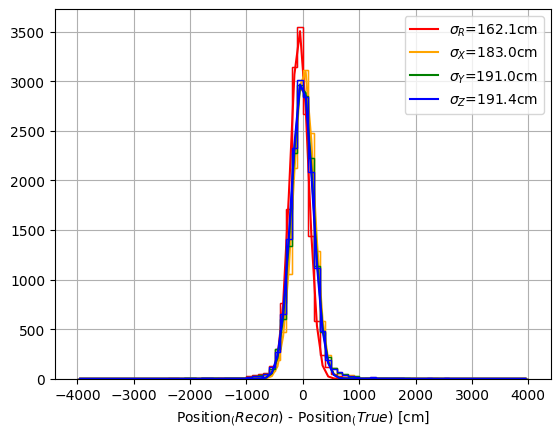

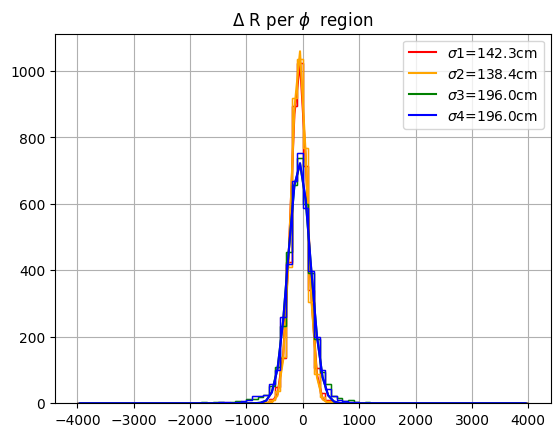

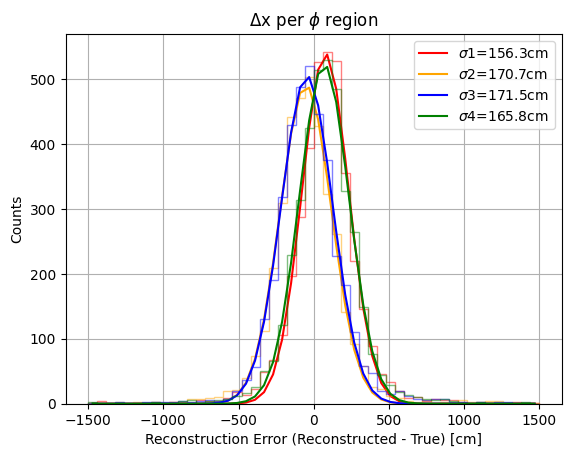

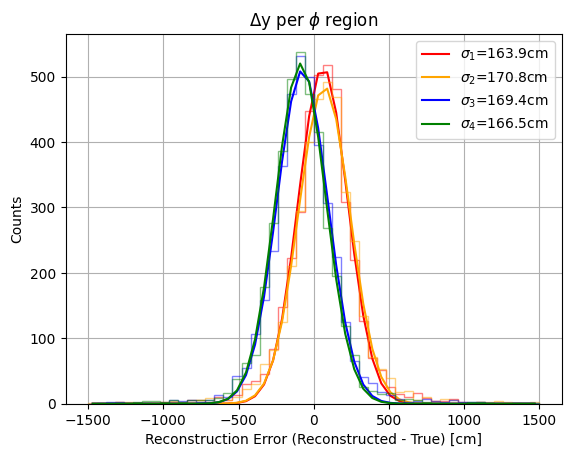

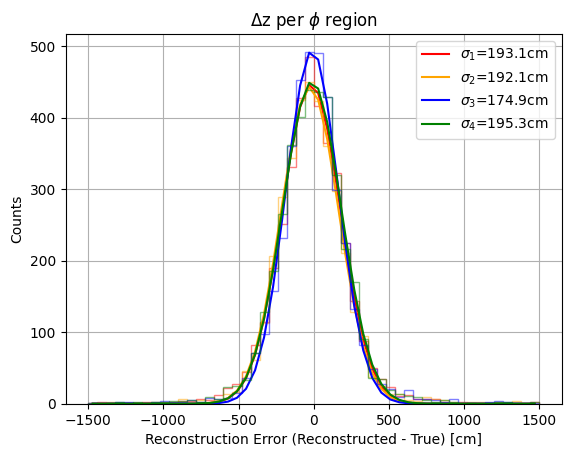

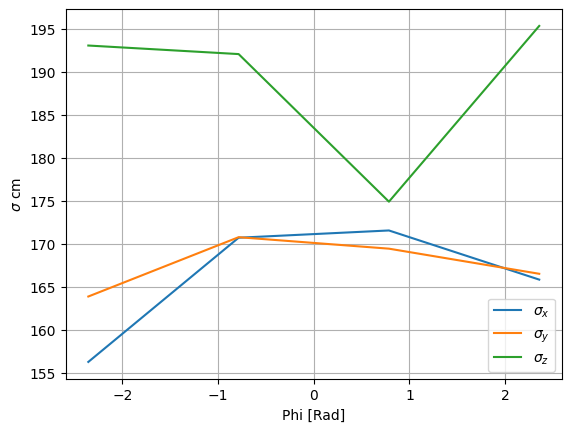

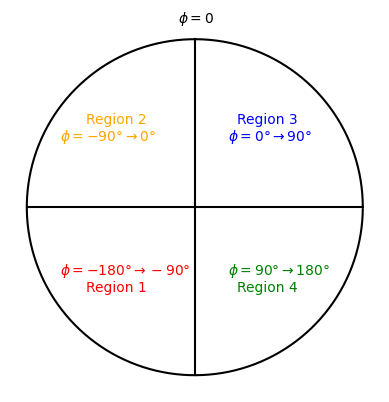

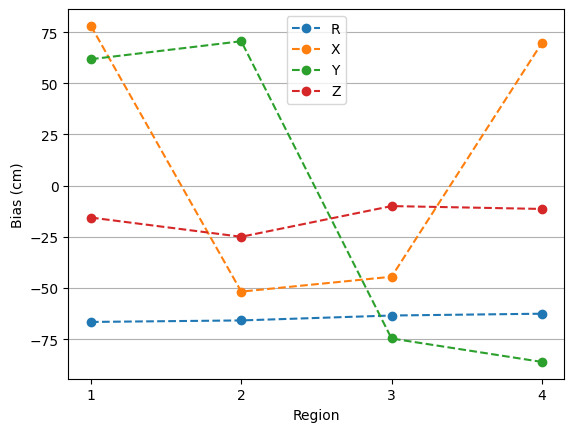

R bias per region: [-67. -66. -63. -63.]
X bias per region: [ 78. -52. -45.  70.]
Y bias per region: [ 62.  71. -75. -86.]
Z bias per region: [-16. -25. -10. -11.]
Mean R bias: 64.62635704961929
Mean X bias: 61.00575372237911
Mean Y bias: 73.2864207653636
Mean Z bias: 15.497022493265407


In [26]:
def cart2pol(x, y):
    rho = np.sqrt(x**2, y**2)
    phi = np.arctan2(y, x)
    return rho, phi

def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return x, y

distance = recons_scaled[:, 1:]-targets_scaled[:,1:]
xdiff = distance[:,0]
ydiff = distance[:,1]
zdiff = distance[:,2]
posR_true, phoPhi_true = cart2pol(targets_scaled[:,1], targets_scaled[:,2])
posR_recon, posPhi_recon = cart2pol(recons_scaled[:,1], recons_scaled[:,2])

posR_diff = posR_recon - posR_true
posPhi_diff = posPhi_recon - posPhi_true

#zp0 = [y_hist_delPhi_z.max(), zdiff.mean(), zdiff.std()]
#zp, zpcov = curve_fit(gaussian, x_hist_delPhi_z, y_hist_delPhi_z, p0=zp0)
#zfit = gaussian(x_hist_delPhi_z, zp[0], zp[1], zp[2])


hist_delPhi_R = plt.hist(posR_diff, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
x_hist_delPhi_R = (hist_delPhi_R[1][1:]+hist_delPhi_R[1][0:-1])/2
y_hist_delPhi_R = hist_delPhi_R[0]
Rp0 = [y_hist_delPhi_R.max(), posR_diff.mean(), posR_diff.std()]
Rp, Rpcov = curve_fit(gaussian, x_hist_delPhi_R, y_hist_delPhi_R, p0 = Rp0)
Rfit = gaussian(x_hist_delPhi_R, Rp[0], Rp[1], Rp[2])
Rlabel=f'$\sigma_R$={np.round(Rp[2], 1)}cm'
plt.plot(x_hist_delPhi_R, Rfit, label=Rlabel, color = 'red')
plt.hist(posR_diff, bins = 80, range=[-4000, 4000], histtype = 'step', color = 'red', lw = 2)

hist_delPhi_x = plt.hist(xdiff, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
x_hist_delPhi_x = (hist_delPhi_x[1][1:]+hist_delPhi_x[1][0:-1])/2
y_hist_delPhi_x = hist_delPhi_x[0]
xp0 = [y_hist_delPhi_x.max(), xdiff.mean(), xdiff.std()]
xp, xpcov = curve_fit(gaussian, x_hist_delPhi_x, y_hist_delPhi_x, p0 = xp0)
xfit = gaussian(x_hist_delPhi_x, xp[0], xp[1], xp[2])
xlabel=f'$\sigma_X$={np.round(xp[2], 1)}cm'
plt.plot(x_hist_delPhi_x, xfit, label=xlabel, color = 'orange')
plt.hist(distance[:,0], bins = 80, range = [-4000,4000], color = 'orange', histtype = 'step', lw=2)


hist_delPhi_y = plt.hist(ydiff, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
x_hist_delPhi_y = (hist_delPhi_y[1][1:]+hist_delPhi_y[1][0:-1])/2
y_hist_delPhi_y = hist_delPhi_y[0]
yp0 = [y_hist_delPhi_y.max(), ydiff.mean(), ydiff.std()]
yp, ypcov = curve_fit(gaussian, x_hist_delPhi_y, y_hist_delPhi_y, p0 = yp0)
yfit = gaussian(x_hist_delPhi_y, yp[0], yp[1], yp[2])
ylabel=f'$\sigma_Y$={np.round(yp[2], 1)}cm'
plt.plot(x_hist_delPhi_y, yfit, label=ylabel, color = 'green')
plt.hist(distance[:,1], bins = 80, range = [-4000,4000], histtype = 'step', lw=2, color = 'green')


hist_delPhi_z = plt.hist(zdiff, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
x_hist_delPhi_z = (hist_delPhi_z[1][1:]+hist_delPhi_z[1][0:-1])/2
y_hist_delPhi_z = hist_delPhi_z[0]
zp0 = [y_hist_delPhi_z.max(), zdiff.mean(), zdiff.std()]
zp, zpcov = curve_fit(gaussian, x_hist_delPhi_z, y_hist_delPhi_z, p0 = zp0)
zfit = gaussian(x_hist_delPhi_z, zp[0], zp[1], zp[2])
zlabel=f'$\sigma_Z$={np.round(zp[2], 1)}cm'
plt.plot(x_hist_delPhi_z, zfit, label=zlabel, color = 'blue')
plt.hist(distance[:,2], bins = 80, range = [-4000,4000], color = 'blue', histtype = 'step', lw=2)
#plt.yscale('log')
plt.xlabel(r'Position$_(Recon)$ - Position$_(True)$ [cm]')
plt.legend()
plt.grid()
plt.show()

#plt.hist(posPhi_diff, bins=80, range=[-2*np.pi, 2*np.pi], label='Phi, std = {:.1f} cm'.format(posPhi_diff.std(axis=0)), color = 'black', histtype = 'step', lw=2)
#plt.yscale('log')
#plt.xlabel(r'position$_(Recon)$-Position$_(True)$ [cm]')
#plt.legend()
#plt.grid()
#plt.show()

posR_true_Reg1, posR_true_Reg2, posR_true_Reg3, posR_true_Reg4 = np.split(posR_true, 4)
posR_recon_Reg1, posR_recon_Reg2, posR_recon_Reg3, posR_recon_Reg4 = np.split(posR_recon, 4)

posR_diff_Reg1 = posR_recon_Reg1 - posR_true_Reg1
posR_diff_Reg2 = posR_recon_Reg2 - posR_true_Reg2
posR_diff_Reg3 = posR_recon_Reg3 - posR_true_Reg3
posR_diff_Reg4 = posR_recon_Reg4 - posR_true_Reg4

posPhi_true_Reg1, posPhi_true_Reg2, posPhi_true_Reg3, posPhi_true_Reg4 = np.split(posPhi_true, 4)
posPhi_recon_Reg1, posPhi_recon_Reg2, posPhi_recon_Reg3, posPhi_recon_Reg4 = np.split(posPhi_recon, 4)


posPhi_diff_Reg1 = posPhi_recon_Reg1 - posPhi_true_Reg1
posPhi_diff_Reg2 = posPhi_recon_Reg2 - posPhi_true_Reg2
posPhi_diff_Reg3 = posPhi_recon_Reg3 - posPhi_true_Reg3
posPhi_diff_Reg4 = posPhi_recon_Reg4 - posPhi_true_Reg4

hist_delPhi_R1 = plt.hist(posR_diff_Reg1, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
x_hist_delPhi_R1 = (hist_delPhi_R1[1][1:]+hist_delPhi_R1[1][0:-1])/2
y_hist_delPhi_R1 = hist_delPhi_R1[0]
R1p0 = [y_hist_delPhi_R1.max(), posR_diff_Reg1.mean(), posR_diff_Reg1.std()]
R1p, R1pcov = curve_fit(gaussian, x_hist_delPhi_R1, y_hist_delPhi_R1, p0 = R1p0)
R1fit = gaussian(x_hist_delPhi_R1, R1p[0], R1p[1], R1p[2])
R1label=f'$\sigma{1}$={np.round(R1p[2], 1)}cm'
plt.plot(x_hist_delPhi_R1, R1fit, label=R1label, color = 'red')
plt.hist(posR_diff_Reg1, bins=80, range = [-4000,4000], color = 'red', histtype = 'step', lw=2)
R1max = R1p[1]
hist_delPhi_R2 = plt.hist(posR_diff_Reg2, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
x_hist_delPhi_R2 = (hist_delPhi_R2[1][1:]+hist_delPhi_R2[1][0:-1])/2
y_hist_delPhi_R2 = hist_delPhi_R2[0]
R2p0 = [y_hist_delPhi_R2.max(), posR_diff_Reg2.mean(), posR_diff_Reg2.std()]
R2p, R2pcov = curve_fit(gaussian, x_hist_delPhi_R2, y_hist_delPhi_R2, p0 = R2p0)
R2fit = gaussian(x_hist_delPhi_R2, R2p[0], R2p[1], R2p[2])
R2label=f'$\sigma{2}$={np.round(R2p[2], 1)}cm'
plt.plot(x_hist_delPhi_R2, R2fit, label=R2label, color = 'orange')
plt.hist(posR_diff_Reg2, bins=80, range = [-4000,4000], histtype = 'step', lw=2, color = 'orange')
R2max = R2p[1]
hist_delPhi_R3 = plt.hist(posR_diff_Reg3, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
x_hist_delPhi_R3 = (hist_delPhi_R3[1][1:]+hist_delPhi_R3[1][0:-1])/2
y_hist_delPhi_R3 = hist_delPhi_R3[0]
R3p0 = [y_hist_delPhi_R3.max(), posR_diff_Reg3.mean(), posR_diff_Reg3.std()]
R3p, R3pcov = curve_fit(gaussian, x_hist_delPhi_R3, y_hist_delPhi_R3, p0 = R3p0)
R3fit = gaussian(x_hist_delPhi_R3, R3p[0], R3p[1], R3p[2])
R3label=f'$\sigma{3}$={np.round(R3p[2], 1)}cm'
plt.plot(x_hist_delPhi_R3, R3fit, label=R3label, color = 'green')
plt.hist(posR_diff_Reg3, bins=80, range = [-4000,4000], histtype = 'step', lw=2, color = 'green')
R3max = R3p[1]
hist_delPhi_R4 = plt.hist(posR_diff_Reg4, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
x_hist_delPhi_R4 = (hist_delPhi_R4[1][1:]+hist_delPhi_R4[1][0:-1])/2
y_hist_delPhi_R4 = hist_delPhi_R4[0]
R4p0 = [y_hist_delPhi_R4.max(), posR_diff_Reg4.mean(), posR_diff_Reg4.std()]
R4p, R4pcov = curve_fit(gaussian, x_hist_delPhi_R4, y_hist_delPhi_R4, p0 = R4p0)
R4fit = gaussian(x_hist_delPhi_R4, R4p[0], R4p[1], R4p[2])
R4label=f'$\sigma{4}$={np.round(R4p[2], 1)}cm'
R4max = R4p[1]
plt.plot(x_hist_delPhi_R4, R4fit, label=R4label, color = 'blue')
plt.hist(posR_diff_Reg4, bins=80, range = [-4000,4000], histtype = 'step', lw=2, color = 'blue')
plt.legend()
plt.title('$\Delta$ R per $\phi$  region')
plt.grid()
plt.show()


phi = np.arctan2(y_recons, x_recons)
phi_regions = [(-np.pi, -np.pi/2), (-np.pi/2, 0), (0, np.pi/2), (np.pi/2, np.pi)]
dx = x_recons - x_target
dy = y_recons - y_target
dz = z_recons - z_target

phi_binned_data = []
for phi_min, phi_max in phi_regions:
    mask = (phi >= phi_min) & (phi < phi_max)
    phi_binned_data.append((dx[mask], dy[mask], dz[mask]))

PHI = []
sigma_Phix = []
Xbias = []
Ybias = []
Zbias = []
color = ['red', 'orange', 'blue', 'green']
for i, (phi_min, phi_max) in enumerate(phi_regions):
    dx_bin, dy_bin, dz_bin = phi_binned_data[i]
    PHI.append((phi_min+phi_max)/2)
    hist_delPhi_x = plt.hist(dx_bin, bins = 50, range = [-1500, 1500], alpha = 0.5, histtype='step', lw=2, color = color[i]) #label = 'X error, std = {:.1f} [cm]'.format(dx_bin.std(axis=0))
    x_hist_delPhi_x = (hist_delPhi_x[1][1:]+hist_delPhi_x[1][0:-1])/2
    y_hist_delPhi_x = hist_delPhi_x[0]
    xp0 = [y_hist_delPhi_x.max(), xdiff.mean(), xdiff.std()]
    xp, xpcov = curve_fit(gaussian, x_hist_delPhi_x, y_hist_delPhi_x, p0=xp0)
    xfit = gaussian(x_hist_delPhi_x, xp[0], xp[1], xp[2])
    xlabel=f'$\sigma{i+1}$={np.round(xp[2], 1)}cm'
    sigma_Phix.append(xp[2])
    plt.plot(x_hist_delPhi_x, xfit, label=xlabel, color = color[i])
    Xbias.append(xp[1])

plt.title(f'$\Delta$x per $\phi$ region')
plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()

PHI = []

sigma_Phiy = []


for i, (phi_min, phi_max) in enumerate(phi_regions):
    dx_bin, dy_bin, dz_bin = phi_binned_data[i]
    PHI.append((phi_min+phi_max)/2)
    hist_delPhi_y = plt.hist(dy_bin, bins = 50, range = [-1500, 1500], alpha = 0.5, histtype='step', lw=2, color = color[i]) # label = 'Y error, std = {:.1f} [cm]'.format(dy_bin.std(axis=0)))
    x_hist_delPhi_y = (hist_delPhi_y[1][1:]+hist_delPhi_y[1][0:-1])/2
    y_hist_delPhi_y = hist_delPhi_y[0]
    yp0 = [y_hist_delPhi_y.max(), ydiff.mean(), ydiff.std()]
    yp, ypcov = curve_fit(gaussian, x_hist_delPhi_y, y_hist_delPhi_y, p0=yp0)
    yfit = gaussian(x_hist_delPhi_y, yp[0], yp[1], yp[2])
    ylabel=f'$\sigma_{i+1}$={np.round(yp[2], 1)}cm'
    sigma_Phiy.append(yp[2])
    plt.plot(x_hist_delPhi_y, yfit, label=ylabel, color = color[i])
    Ybias.append(yp[1])
plt.title(f'$\Delta$y per $\phi$ region')
plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()
PHI = []

sigma_Phiz = []
for i, (phi_min, phi_max) in enumerate(phi_regions):
    dx_bin, dy_bin, dz_bin = phi_binned_data[i]
    PHI.append((phi_min+phi_max)/2)
    hist_delPhi_z = plt.hist(dz_bin, bins = 50, range = [-1500, 1500], alpha = 0.5, histtype='step', lw=2, color = color[i]) #label = 'Z reg{:.1f}, std = {:.1f} [cm]'.format(i, dz_bin.std(axis=0)))
    x_hist_delPhi_z = (hist_delPhi_z[1][1:]+hist_delPhi_z[1][0:-1])/2
    y_hist_delPhi_z = hist_delPhi_z[0]
    zp0 = [y_hist_delPhi_z.max(), zdiff.mean(), zdiff.std()]
    zp, zpcov = curve_fit(gaussian, x_hist_delPhi_z, y_hist_delPhi_z, p0=zp0)
    zfit = gaussian(x_hist_delPhi_z, zp[0], zp[1], zp[2])
    zlabel=f'$\sigma_{i+1}$={np.round(zp[2], 1)}cm'
    sigma_Phiz.append(zp[2])
    Zbias.append(zp[1])
    
    
    plt.plot(x_hist_delPhi_z, zfit, label=zlabel, color = color[i])
plt.title(f'$\Delta$z per $\phi$ region')
plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()

plt.plot(PHI,sigma_Phix, label = '$\sigma_x$')
plt.plot(PHI, sigma_Phiy, label = '$\sigma_y$')
plt.plot(PHI, sigma_Phiz, label = '$\sigma_z$')
plt.xlabel('Phi [Rad]')
plt.ylabel('$\sigma$ cm')
plt.legend()
plt.grid()
plt.show()

def xy(r,phi):
  return r*np.cos(phi), r*np.sin(phi)

fig = plt.figure()
ax = fig.add_subplot(111,aspect='equal')  

phis=np.arange(0,6.28,0.01)
r =1.
x = np.linspace(-r, r, 1000)
y = np.linspace(-r, r, 1000)
x0 = np.zeros(len(x))
ax.plot( *xy(r,phis), c='k',ls='-' )
ax.plot(x, x0, color = 'k')
ax.plot(x0, x, color = 'k')
ax.annotate(r'$\phi = -180\degree \rightarrow -90\degree$', (-0.8, -0.4), color = 'red')
ax.annotate('Region 1', (-0.65, -0.5), color = 'red')
ax.annotate(r'$\phi = -90\degree \rightarrow 0\degree$', (-0.8, 0.4), color = 'orange')
ax.annotate('Region 2', (-0.65, 0.5), color = 'orange')
ax.annotate(r'$\phi = 0\degree \rightarrow 90\degree$', (0.2, 0.4), color = 'blue')
ax.annotate('Region 3', (0.25, 0.5), color = 'blue')
ax.annotate(r'$\phi = 90\degree \rightarrow 180\degree$', (0.2, -0.4), color = 'green')
ax.annotate('Region 4', (0.25, -0.5), color = 'green')
ax.annotate(r'$\phi = 0$', (-0.1, 1.1))
ax.axes.set_axis_off()
plt.show()
X = [1, 2, 3, 4]
R = [R1max, R2max, R3max, R4max]
plt.plot(X, R, label = 'R', linestyle = 'dashed', marker = 'o')
plt.plot(X, Xbias, label = 'X', linestyle = 'dashed', marker = 'o')
plt.plot(X, Ybias, label = 'Y', linestyle = 'dashed', marker = 'o')
plt.plot(X, Zbias, label = 'Z', linestyle = 'dashed', marker = 'o')
plt.xticks([1, 2, 3, 4])
plt.xlabel('Region')
plt.ylabel('Bias (cm)')
plt.grid(axis = 'y')
plt.legend()
plt.show()

print('R bias per region: {}'.format(np.round(R)))
print('X bias per region: {}'.format(np.round(Xbias)))
print('Y bias per region: {}'.format(np.round(Ybias)))
print('Z bias per region: {}'.format(np.round(Zbias)))

print('Mean R bias: {}'.format(np.mean(np.abs(R))))
print('Mean X bias: {}'.format(np.mean(np.abs(Xbias))))
print('Mean Y bias: {}'.format(np.mean(np.abs(Ybias))))
print('Mean Z bias: {}'.format(np.mean(np.abs(Zbias))))






(7500, 4)
(7500, 4)


<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:56: SyntaxWarning: invalid escape sequence '\s'
<>:67: SyntaxWarning: invalid escape sequence '\s'
<>:107: SyntaxWarning: invalid escape sequence '\s'
<>:117: SyntaxWarning: invalid escape sequence '\s'
<>:127: SyntaxWarning: invalid escape sequence '\s'
<>:137: SyntaxWarning: invalid escape sequence '\s'
<>:142: SyntaxWarning: invalid escape sequence '\D'
<>:173: SyntaxWarning: invalid escape sequence '\s'
<>:178: SyntaxWarning: invalid escape sequence '\D'
<>:199: SyntaxWarning: invalid escape sequence '\s'
<>:203: SyntaxWarning: invalid escape sequence '\D'
<>:221: SyntaxWarning: invalid escape sequence '\s'
<>:227: SyntaxWarning: invalid escape sequence '\D'
<>:234: SyntaxWarning: invalid escape sequence '\s'
<>:235: SyntaxWarning: invalid escape sequence '\s'
<>:236: SyntaxWarning: invalid escape sequence '\s'
<>:239: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWar

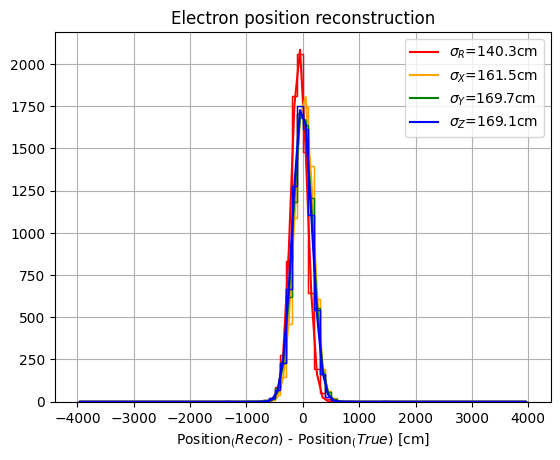

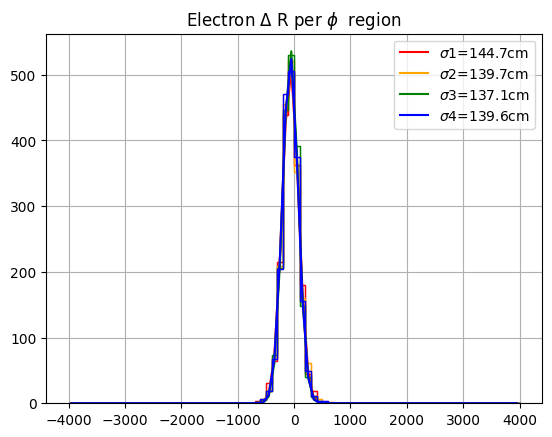

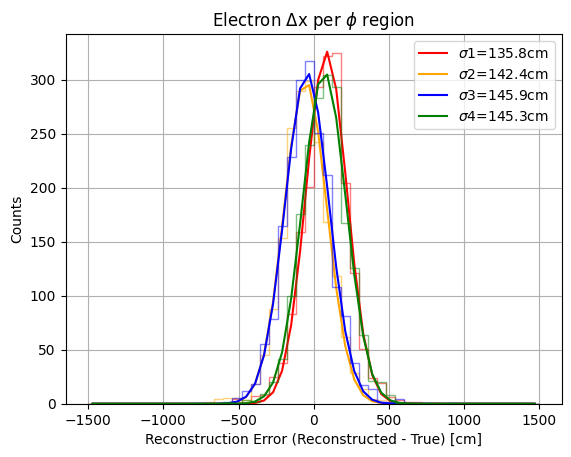

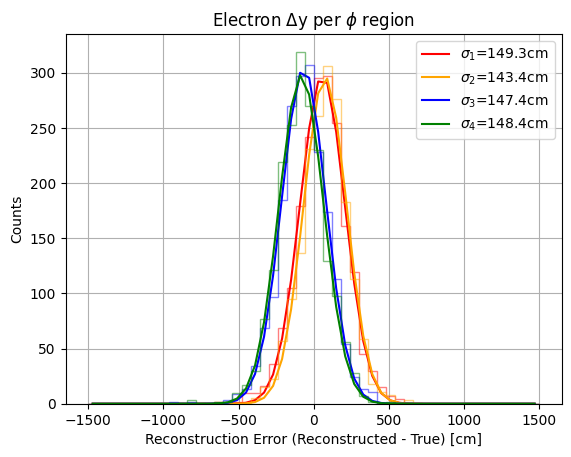

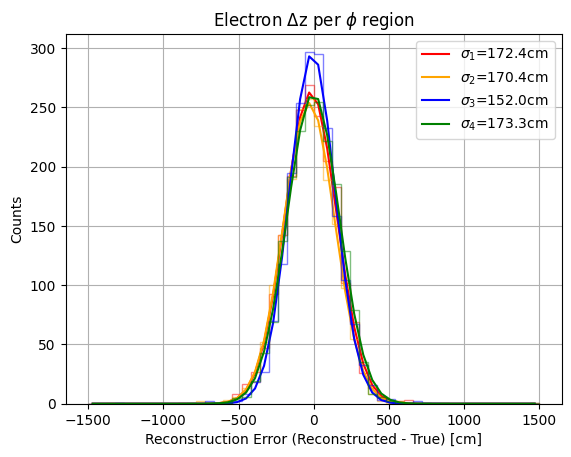

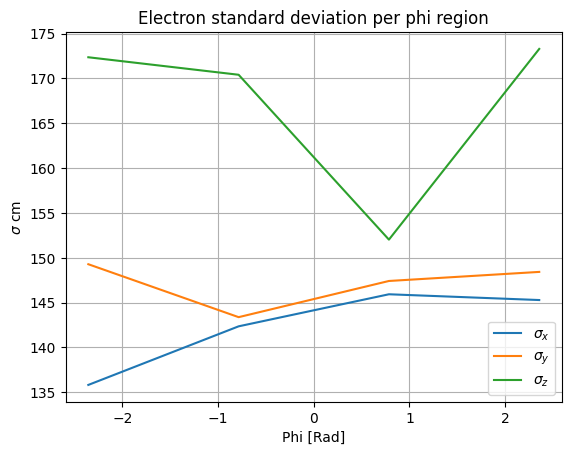

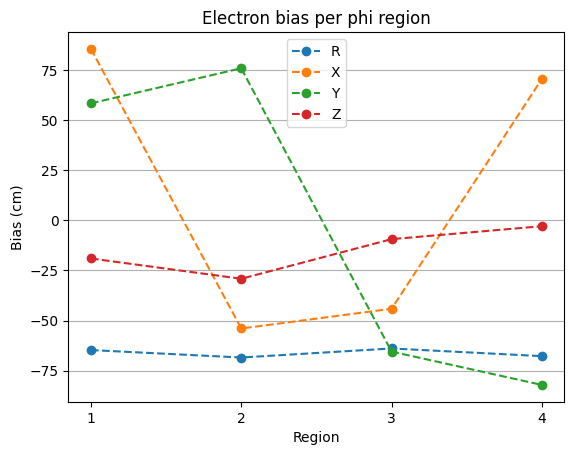

R bias per region: [-65. -68. -64. -68.]
X bias per region: [ 86. -54. -44.  71.]
Y bias per region: [ 58.  76. -65. -82.]
Z bias per region: [-19. -29.  -9.  -3.]
Mean R bias: 66.22069084795011
Mean X bias: 63.54899230693644
Mean Y bias: 70.4788576967222
Mean Z bias: 15.12195611583851
(7500, 4)
(7500, 4)


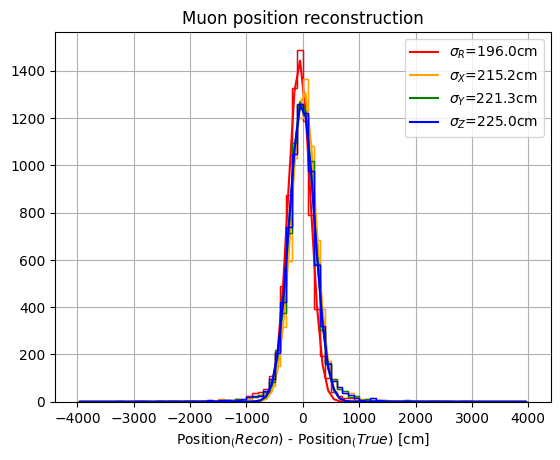

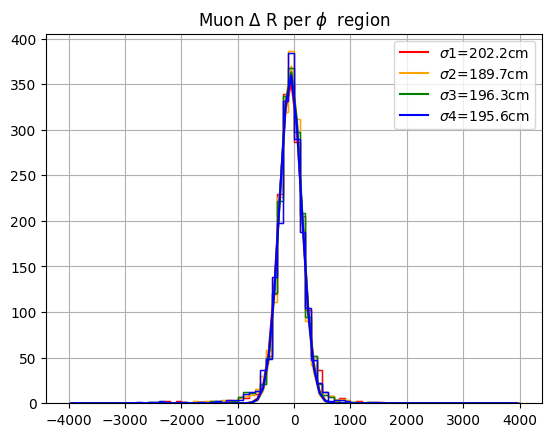

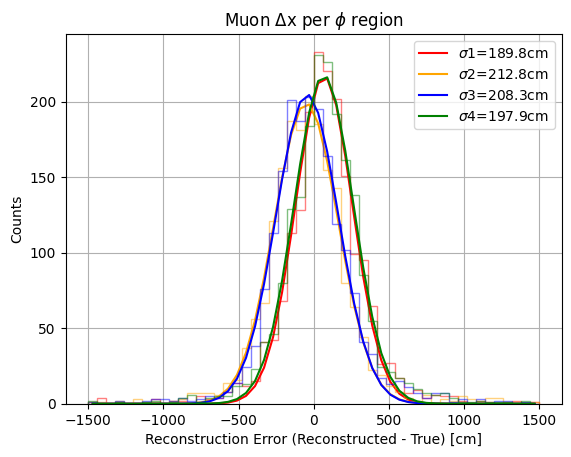

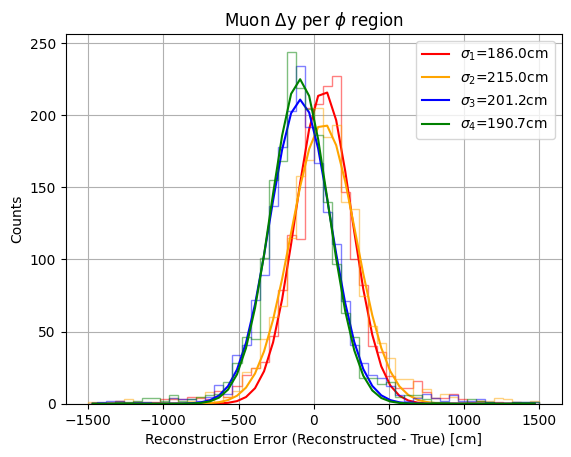

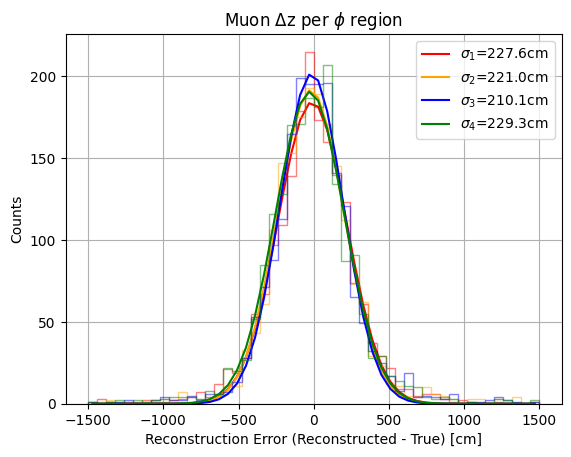

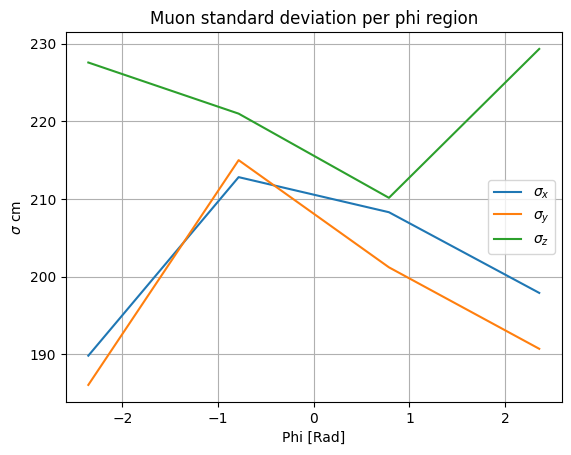

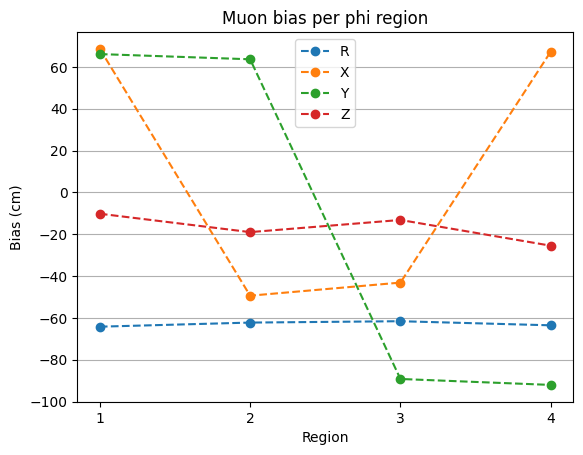

R bias per region: [-64. -62. -62. -64.]
X bias per region: [ 69. -49. -43.  67.]
Y bias per region: [ 66.  64. -89. -92.]
Z bias per region: [-10. -19. -13. -25.]
Mean R bias: 62.90825047389448
Mean X bias: 57.11732673907228
Mean Y bias: 77.78130348561291
Mean Z bias: 16.959128320200612
(7500, 4)


In [27]:
def particle_separator_position(recons_scaled, targets_scaled, particle):

    def cart2pol(x, y):
        rho = np.sqrt(x**2, y**2)
        phi = np.arctan2(y, x)
        return rho, phi

    def pol2cart(r, phi):
        x = r * np.cos(phi)
        y = r * np.sin(phi)
        return x, y
    print(targets_scaled.shape)
    print(recons_scaled.shape)
    distance = recons_scaled[:, 1:]-targets_scaled[:,1:]
    xdiff = distance[:,0]
    ydiff = distance[:,1]
    zdiff = distance[:,2]
    posR_true, phoPhi_true = cart2pol(targets_scaled[:,1], targets_scaled[:,2])
    posR_recon, posPhi_recon = cart2pol(recons_scaled[:,1], recons_scaled[:,2])

    posR_diff = posR_recon - posR_true
    #posPhi_diff = posPhi_recon - posPhi_true

    #zp0 = [y_hist_delPhi_z.max(), zdiff.mean(), zdiff.std()]
    #zp, zpcov = curve_fit(gaussian, x_hist_delPhi_z, y_hist_delPhi_z, p0=zp0)
    #zfit = gaussian(x_hist_delPhi_z, zp[0], zp[1], zp[2])


    hist_delPhi_R = plt.hist(posR_diff, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
    x_hist_delPhi_R = (hist_delPhi_R[1][1:]+hist_delPhi_R[1][0:-1])/2
    y_hist_delPhi_R = hist_delPhi_R[0]
    Rp0 = [y_hist_delPhi_R.max(), posR_diff.mean(), posR_diff.std()]
    Rp, Rpcov = curve_fit(gaussian, x_hist_delPhi_R, y_hist_delPhi_R, p0 = Rp0)
    Rfit = gaussian(x_hist_delPhi_R, Rp[0], Rp[1], Rp[2])
    Rlabel=f'$\sigma_R$={np.round(Rp[2], 1)}cm'
    plt.plot(x_hist_delPhi_R, Rfit, label=Rlabel, color = 'red')
    plt.hist(posR_diff, bins = 80, range=[-4000, 4000], histtype = 'step', color = 'red', lw = 2)

    hist_delPhi_x = plt.hist(xdiff, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
    x_hist_delPhi_x = (hist_delPhi_x[1][1:]+hist_delPhi_x[1][0:-1])/2
    y_hist_delPhi_x = hist_delPhi_x[0]
    xp0 = [y_hist_delPhi_x.max(), xdiff.mean(), xdiff.std()]
    xp, xpcov = curve_fit(gaussian, x_hist_delPhi_x, y_hist_delPhi_x, p0 = xp0)
    xfit = gaussian(x_hist_delPhi_x, xp[0], xp[1], xp[2])
    xlabel=f'$\sigma_X$={np.round(xp[2], 1)}cm'
    plt.plot(x_hist_delPhi_x, xfit, label=xlabel, color = 'orange')
    plt.hist(distance[:,0], bins = 80, range = [-4000,4000], color = 'orange', histtype = 'step', lw=2)


    hist_delPhi_y = plt.hist(ydiff, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
    x_hist_delPhi_y = (hist_delPhi_y[1][1:]+hist_delPhi_y[1][0:-1])/2
    y_hist_delPhi_y = hist_delPhi_y[0]
    yp0 = [y_hist_delPhi_y.max(), ydiff.mean(), ydiff.std()]
    yp, ypcov = curve_fit(gaussian, x_hist_delPhi_y, y_hist_delPhi_y, p0 = yp0)
    yfit = gaussian(x_hist_delPhi_y, yp[0], yp[1], yp[2])
    ylabel=f'$\sigma_Y$={np.round(yp[2], 1)}cm'
    plt.plot(x_hist_delPhi_y, yfit, label=ylabel, color = 'green')
    plt.hist(distance[:,1], bins = 80, range = [-4000,4000], histtype = 'step', lw=2, color = 'green')


    hist_delPhi_z = plt.hist(zdiff, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
    x_hist_delPhi_z = (hist_delPhi_z[1][1:]+hist_delPhi_z[1][0:-1])/2
    y_hist_delPhi_z = hist_delPhi_z[0]
    zp0 = [y_hist_delPhi_z.max(), zdiff.mean(), zdiff.std()]
    zp, zpcov = curve_fit(gaussian, x_hist_delPhi_z, y_hist_delPhi_z, p0 = zp0)
    zfit = gaussian(x_hist_delPhi_z, zp[0], zp[1], zp[2])
    zlabel=f'$\sigma_Z$={np.round(zp[2], 1)}cm'
    plt.plot(x_hist_delPhi_z, zfit, label=zlabel, color = 'blue')
    plt.hist(distance[:,2], bins = 80, range = [-4000,4000], color = 'blue', histtype = 'step', lw=2)
    #plt.yscale('log')
    plt.xlabel(r'Position$_(Recon)$ - Position$_(True)$ [cm]')
    plt.title(f'{particle} position reconstruction')
    plt.legend()
    plt.grid()
    plt.show()

    #plt.hist(posPhi_diff, bins=80, range=[-2*np.pi, 2*np.pi], label='Phi, std = {:.1f} cm'.format(posPhi_diff.std(axis=0)), color = 'black', histtype = 'step', lw=2)
    #plt.yscale('log')
    #plt.xlabel(r'position$_(Recon)$-Position$_(True)$ [cm]')
    #plt.legend()
    #plt.grid()
    #plt.show()

    posR_true_Reg1, posR_true_Reg2, posR_true_Reg3, posR_true_Reg4 = np.split(posR_true, 4)
    posR_recon_Reg1, posR_recon_Reg2, posR_recon_Reg3, posR_recon_Reg4 = np.split(posR_recon, 4)

    posR_diff_Reg1 = posR_recon_Reg1 - posR_true_Reg1
    posR_diff_Reg2 = posR_recon_Reg2 - posR_true_Reg2
    posR_diff_Reg3 = posR_recon_Reg3 - posR_true_Reg3
    posR_diff_Reg4 = posR_recon_Reg4 - posR_true_Reg4

    posPhi_true_Reg1, posPhi_true_Reg2, posPhi_true_Reg3, posPhi_true_Reg4 = np.split(posPhi_true, 4)
    posPhi_recon_Reg1, posPhi_recon_Reg2, posPhi_recon_Reg3, posPhi_recon_Reg4 = np.split(posPhi_recon, 4)


    #posPhi_diff_Reg1 = posPhi_recon_Reg1 - posPhi_true_Reg1
    #posPhi_diff_Reg2 = posPhi_recon_Reg2 - posPhi_true_Reg2
    #posPhi_diff_Reg3 = posPhi_recon_Reg3 - posPhi_true_Reg3
    #posPhi_diff_Reg4 = posPhi_recon_Reg4 - posPhi_true_Reg4

    hist_delPhi_R1 = plt.hist(posR_diff_Reg1, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
    x_hist_delPhi_R1 = (hist_delPhi_R1[1][1:]+hist_delPhi_R1[1][0:-1])/2
    y_hist_delPhi_R1 = hist_delPhi_R1[0]
    R1p0 = [y_hist_delPhi_R1.max(), posR_diff_Reg1.mean(), posR_diff_Reg1.std()]
    R1p, R1pcov = curve_fit(gaussian, x_hist_delPhi_R1, y_hist_delPhi_R1, p0 = R1p0)
    R1fit = gaussian(x_hist_delPhi_R1, R1p[0], R1p[1], R1p[2])
    R1label=f'$\sigma{1}$={np.round(R1p[2], 1)}cm'
    plt.plot(x_hist_delPhi_R1, R1fit, label=R1label, color = 'red')
    plt.hist(posR_diff_Reg1, bins=80, range = [-4000,4000], color = 'red', histtype = 'step', lw=2)
    R1max = R1p[1]
    hist_delPhi_R2 = plt.hist(posR_diff_Reg2, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
    x_hist_delPhi_R2 = (hist_delPhi_R2[1][1:]+hist_delPhi_R2[1][0:-1])/2
    y_hist_delPhi_R2 = hist_delPhi_R2[0]
    R2p0 = [y_hist_delPhi_R2.max(), posR_diff_Reg2.mean(), posR_diff_Reg2.std()]
    R2p, R2pcov = curve_fit(gaussian, x_hist_delPhi_R2, y_hist_delPhi_R2, p0 = R2p0)
    R2fit = gaussian(x_hist_delPhi_R2, R2p[0], R2p[1], R2p[2])
    R2label=f'$\sigma{2}$={np.round(R2p[2], 1)}cm'
    plt.plot(x_hist_delPhi_R2, R2fit, label=R2label, color = 'orange')
    plt.hist(posR_diff_Reg2, bins=80, range = [-4000,4000], histtype = 'step', lw=2, color = 'orange')
    R2max = R2p[1]
    hist_delPhi_R3 = plt.hist(posR_diff_Reg3, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
    x_hist_delPhi_R3 = (hist_delPhi_R3[1][1:]+hist_delPhi_R3[1][0:-1])/2
    y_hist_delPhi_R3 = hist_delPhi_R3[0]
    R3p0 = [y_hist_delPhi_R3.max(), posR_diff_Reg3.mean(), posR_diff_Reg3.std()]
    R3p, R3pcov = curve_fit(gaussian, x_hist_delPhi_R3, y_hist_delPhi_R3, p0 = R3p0)
    R3fit = gaussian(x_hist_delPhi_R3, R3p[0], R3p[1], R3p[2])
    R3label=f'$\sigma{3}$={np.round(R3p[2], 1)}cm'
    plt.plot(x_hist_delPhi_R3, R3fit, label=R3label, color = 'green')
    plt.hist(posR_diff_Reg3, bins=80, range = [-4000,4000], histtype = 'step', lw=2, color = 'green')
    R3max = R3p[1]
    hist_delPhi_R4 = plt.hist(posR_diff_Reg4, bins=80, range = [-4000,4000], histtype = 'step', lw=2, alpha = 0.5)
    x_hist_delPhi_R4 = (hist_delPhi_R4[1][1:]+hist_delPhi_R4[1][0:-1])/2
    y_hist_delPhi_R4 = hist_delPhi_R4[0]
    R4p0 = [y_hist_delPhi_R4.max(), posR_diff_Reg4.mean(), posR_diff_Reg4.std()]
    R4p, R4pcov = curve_fit(gaussian, x_hist_delPhi_R4, y_hist_delPhi_R4, p0 = R4p0)
    R4fit = gaussian(x_hist_delPhi_R4, R4p[0], R4p[1], R4p[2])
    R4label=f'$\sigma{4}$={np.round(R4p[2], 1)}cm'
    R4max = R4p[1]
    plt.plot(x_hist_delPhi_R4, R4fit, label=R4label, color = 'blue')
    plt.hist(posR_diff_Reg4, bins=80, range = [-4000,4000], histtype = 'step', lw=2, color = 'blue')
    plt.legend()
    plt.title(f'{particle} $\Delta$ R per $\phi$  region')
    plt.grid()
    plt.show()


    phi = np.arctan2(recons_scaled[:,2],recons_scaled[:,1])
    phi_regions = [(-np.pi, -np.pi/2), (-np.pi/2, 0), (0, np.pi/2), (np.pi/2, np.pi)]
    dx = xdiff
    dy = ydiff
    dz = zdiff

    phi_binned_data = []
    for phi_min, phi_max in phi_regions:
        mask = (phi >= phi_min) & (phi < phi_max)
        phi_binned_data.append((dx[mask], dy[mask], dz[mask]))

    PHI = []
    sigma_Phix = []
    Xbias = []
    Ybias = []
    Zbias = []
    color = ['red', 'orange', 'blue', 'green']
    for i, (phi_min, phi_max) in enumerate(phi_regions):
        dx_bin, dy_bin, dz_bin = phi_binned_data[i]
        PHI.append((phi_min+phi_max)/2)
        hist_delPhi_x = plt.hist(dx_bin, bins = 50, range = [-1500, 1500], alpha = 0.5, histtype='step', lw=2, color = color[i]) #label = 'X error, std = {:.1f} [cm]'.format(dx_bin.std(axis=0))
        x_hist_delPhi_x = (hist_delPhi_x[1][1:]+hist_delPhi_x[1][0:-1])/2
        y_hist_delPhi_x = hist_delPhi_x[0]
        xp0 = [y_hist_delPhi_x.max(), xdiff.mean(), xdiff.std()]
        xp, xpcov = curve_fit(gaussian, x_hist_delPhi_x, y_hist_delPhi_x, p0=xp0)
        xfit = gaussian(x_hist_delPhi_x, xp[0], xp[1], xp[2])
        xlabel=f'$\sigma{i+1}$={np.round(xp[2], 1)}cm'
        sigma_Phix.append(xp[2])
        plt.plot(x_hist_delPhi_x, xfit, label=xlabel, color = color[i])
        Xbias.append(xp[1])

    plt.title(f'{particle} $\Delta$x per $\phi$ region')
    plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()

    PHI = []

    sigma_Phiy = []


    for i, (phi_min, phi_max) in enumerate(phi_regions):
        dx_bin, dy_bin, dz_bin = phi_binned_data[i]
        PHI.append((phi_min+phi_max)/2)
        hist_delPhi_y = plt.hist(dy_bin, bins = 50, range = [-1500, 1500], alpha = 0.5, histtype='step', lw=2, color = color[i]) # label = 'Y error, std = {:.1f} [cm]'.format(dy_bin.std(axis=0)))
        x_hist_delPhi_y = (hist_delPhi_y[1][1:]+hist_delPhi_y[1][0:-1])/2
        y_hist_delPhi_y = hist_delPhi_y[0]
        yp0 = [y_hist_delPhi_y.max(), ydiff.mean(), ydiff.std()]
        yp, ypcov = curve_fit(gaussian, x_hist_delPhi_y, y_hist_delPhi_y, p0=yp0)
        yfit = gaussian(x_hist_delPhi_y, yp[0], yp[1], yp[2])
        ylabel=f'$\sigma_{i+1}$={np.round(yp[2], 1)}cm'
        sigma_Phiy.append(yp[2])
        plt.plot(x_hist_delPhi_y, yfit, label=ylabel, color = color[i])
        Ybias.append(yp[1])
    plt.title(f'{particle} $\Delta$y per $\phi$ region')
    plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()
    PHI = []

    sigma_Phiz = []
    for i, (phi_min, phi_max) in enumerate(phi_regions):
        dx_bin, dy_bin, dz_bin = phi_binned_data[i]
        PHI.append((phi_min+phi_max)/2)
        hist_delPhi_z = plt.hist(dz_bin, bins = 50, range = [-1500, 1500], alpha = 0.5, histtype='step', lw=2, color = color[i]) #label = 'Z reg{:.1f}, std = {:.1f} [cm]'.format(i, dz_bin.std(axis=0)))
        x_hist_delPhi_z = (hist_delPhi_z[1][1:]+hist_delPhi_z[1][0:-1])/2
        y_hist_delPhi_z = hist_delPhi_z[0]
        zp0 = [y_hist_delPhi_z.max(), zdiff.mean(), zdiff.std()]
        zp, zpcov = curve_fit(gaussian, x_hist_delPhi_z, y_hist_delPhi_z, p0=zp0)
        zfit = gaussian(x_hist_delPhi_z, zp[0], zp[1], zp[2])
        zlabel=f'$\sigma_{i+1}$={np.round(zp[2], 1)}cm'
        sigma_Phiz.append(zp[2])
        Zbias.append(zp[1])
    
    
        plt.plot(x_hist_delPhi_z, zfit, label=zlabel, color = color[i])
    plt.title(f'{particle} $\Delta$z per $\phi$ region')
    plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(PHI,sigma_Phix, label = '$\sigma_x$')
    plt.plot(PHI, sigma_Phiy, label = '$\sigma_y$')
    plt.plot(PHI, sigma_Phiz, label = '$\sigma_z$')
    plt.title(f'{particle} standard deviation per phi region')
    plt.xlabel('Phi [Rad]')
    plt.ylabel('$\sigma$ cm')
    plt.legend()
    plt.grid()
    plt.show()

    X = [1, 2, 3, 4]
    R = [R1max, R2max, R3max, R4max]
    plt.plot(X, R, label = 'R', linestyle = 'dashed', marker = 'o')
    plt.plot(X, Xbias, label = 'X', linestyle = 'dashed', marker = 'o')
    plt.plot(X, Ybias, label = 'Y', linestyle = 'dashed', marker = 'o')
    plt.plot(X, Zbias, label = 'Z', linestyle = 'dashed', marker = 'o')
    plt.xticks([1, 2, 3, 4])
    plt.xlabel('Region')
    plt.ylabel('Bias (cm)')
    plt.grid(axis = 'y')
    plt.title(f'{particle} bias per phi region')
    plt.legend()
    plt.show()

    print('R bias per region: {}'.format(np.round(R)))
    print('X bias per region: {}'.format(np.round(Xbias)))
    print('Y bias per region: {}'.format(np.round(Ybias)))
    print('Z bias per region: {}'.format(np.round(Zbias)))

    print('Mean R bias: {}'.format(np.mean(np.abs(R))))
    print('Mean X bias: {}'.format(np.mean(np.abs(Xbias))))
    print('Mean Y bias: {}'.format(np.mean(np.abs(Ybias))))
    print('Mean Z bias: {}'.format(np.mean(np.abs(Zbias))))

erecons_scaled = recons_scaled[eevents]
etargets_scaled = targets_scaled[eevents]
eparticle = 'Electron'

mrecons_scaled = recons_scaled[mevents]
mtargets_scaled = targets_scaled[mevents]
mparticle = 'Muon'

particle_separator_position(erecons_scaled, etargets_scaled, eparticle)
particle_separator_position(mrecons_scaled, mtargets_scaled, mparticle)

print(erecons_scaled.shape)


<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:75: SyntaxWarning: invalid escape sequence '\s'
<>:79: SyntaxWarning: invalid escape sequence '\D'
<>:115: SyntaxWarning: invalid escape sequence '\s'
<>:119: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:75: SyntaxWarning: invalid escape sequence '\s'
<>:79: SyntaxWarning: invalid escape sequence '\D'
<>:115: SyntaxWarning: invalid escape sequence '\s'
<>:119: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1213193/570221113.py:32: SyntaxWarning: invalid escape sequence '\s'
  label='$\sigma$={:.1f}%'.format(p[2])
/tmp/ipykernel_1213193/570221113.py:35: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E%')
/tmp/ipykernel_1213193/570221113.py:45: SyntaxW

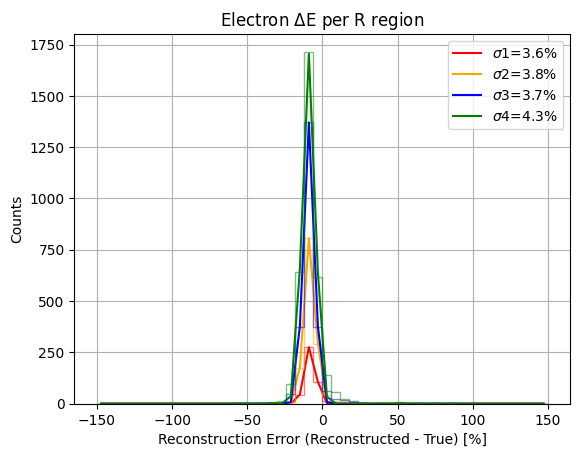

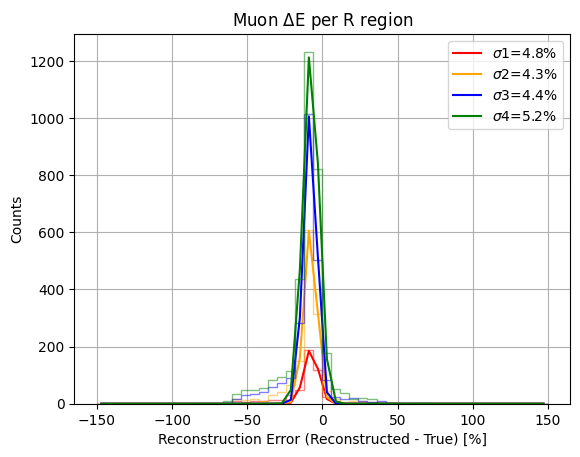

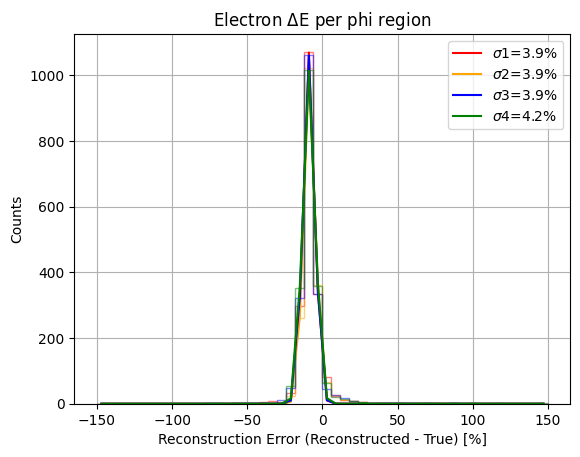

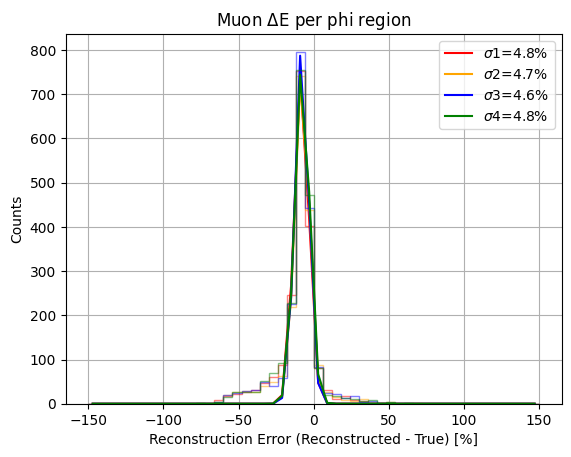

In [28]:
def particle_separator_energy_asfnof_Rtest(recons_scaled, targets_scaled, particle):
    def binning(target, x, bin_width, bin_range):
        bins = int((bin_range[1]-bin_range[0])/bin_width)
        binned = []
        for i in range(bins):
            binned.append(x[((target>=(bin_range[0]+i*bin_width))&(target<(bin_range[0]+(i+1)*bin_width)))])

        return binned

    bias=(recons_scaled-targets_scaled)/targets_scaled * 100. # %
    # Energy resolution
    #delE=difference[:,1]
    delE=bias[:,0]

    radius_range=[0,3000]
    bin_width=500
    delE_binned=binning(targets_scaled[:,0], delE, bin_width=bin_width, bin_range=radius_range)

    sigma_E=[]
    E=[]
    for i in range(len(delE_binned)):
        lower=energy_range[0]+bin_width*i
        higher=energy_range[0]+bin_width*(i+1)
        E.append(lower+(higher-lower)/2.)
        label='{:d} < Energy [MeV] < {:d}'.format(lower,higher)
        hist_delE=plt.hist(delE_binned[i], bins=50, range=[-120,120], label=label , histtype='step', lw=2, density=False)
        x_hist_delE = (hist_delE[1][1:]+hist_delE[1][0:-1])/2.
        y_hist_delE = hist_delE[0]
        p0 = [y_hist_delE.max(), delE.mean(), delE.std()]
        p, pcov = curve_fit(gaussian, x_hist_delE, y_hist_delE, p0=p0)
        fit=gaussian(x_hist_delE, p[0], p[1], p[2])
        label='$\sigma$={:.1f}%'.format(p[2])
        sigma_E.append(p[2])
        plt.plot(x_hist_delE, fit, label=label)
        plt.xlabel('$\Delta$E%')
        plt.legend()
        plt.title(f'{particle} energy resolution')
        plt.grid()
        plt.show()

    plt.plot(E,sigma_E)
    plt.xlim([0.,None])
    plt.ylim([0.,None])
    plt.xlabel('Energy [MeV]')
    plt.ylabel('$\sigma_{E}$ %')
    plt.title(f'{particle} energy standard deviation')
    plt.grid()
    plt.show()

def particle_separator_energy_asfnof_radius(recons_scaled, targets_scaled, particle, particler):
    erecon = recons_scaled[:,0]
    etrue = targets_scaled[:,0]
    ediff = ((erecon-etrue)/etrue)*100
    rho_target = np.sqrt(targets_scaled[:,1]**2+targets_scaled[:,2]**2)
    r_binned_data = []
    re = particler
    r_regions = [(0, 750), (750, 1500), (1500, 2250), (2250, max(rho_target))]
    for r_min, r_max in r_regions:
        mask = (re >= r_min) & (re < r_max)
        r_binned_data.append(ediff[mask])
    
    R = []
    sigma_Re = []

    color = ['red', 'orange', 'blue', 'green']
    for i, (r_min, r_max) in enumerate(r_regions):
        ediff = r_binned_data[i]
        R.append((r_min+r_max)/2)
        hist_delPhi_e = plt.hist(ediff, bins = 50, range = [-150, 150], alpha = 0.5, histtype='step', lw=2, color = color[i]) #label = 'X error, std = {:.1f} [cm]'.format(dx_bin.std(axis=0))
        x_hist_delPhi_e = (hist_delPhi_e[1][1:]+hist_delPhi_e[1][0:-1])/2
        y_hist_delPhi_e = hist_delPhi_e[0]
        ep0 = [y_hist_delPhi_e.max(), ediff.mean(), ediff.std()]
        ep, epcov = curve_fit(gaussian, x_hist_delPhi_e, y_hist_delPhi_e, p0=ep0)
        efit = gaussian(x_hist_delPhi_e, ep[0], ep[1], ep[2])
        elabel=f'$\sigma{i+1}$={np.round(ep[2], 1)}%'
        sigma_Re.append(ep[2])
        plt.plot(x_hist_delPhi_e, efit, label=elabel, color = color[i])

    plt.title(f'{particle} $\Delta$E per R region')
    plt.xlabel('Reconstruction Error (Reconstructed - True) [%]')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()

eparticler = rho_target[eevents]
mparticler = rho_target[mevents]
particle_separator_energy_asfnof_radius(erecons_scaled, etargets_scaled, eparticle, eparticler)
particle_separator_energy_asfnof_radius(mrecons_scaled, mtargets_scaled, mparticle, mparticler)

def particle_separator_energy_asfnof_phi(recons_scaled, targets_scaled, particle):
    erecon = recons_scaled[:,0] 
    etrue = targets_scaled[:,0]
    ediff = ((erecon-etrue)/etrue)*100
    phi_target = np.arctan2(targets_scaled[:,2], targets_scaled[:,1])
    phi_binned_data = []
    phi_regions = [(-np.pi, -1*np.pi/2), (-1*np.pi/2, 0), (0, 1*np.pi/2), (1*np.pi/2, np.pi)]
    for phi_min, phi_max in phi_regions:
        mask = (phi_target >= phi_min) & (phi_target < phi_max)
        phi_binned_data.append(ediff[mask])
    
    PHI = []
    sigma_Phie = []

    color = ['red', 'orange', 'blue', 'green']
    for i, (Phi_min, Phi_max) in enumerate(phi_regions):
        ediff = phi_binned_data[i]
        PHI.append((phi_min+phi_max)/2)
        hist_delPhi_e = plt.hist(ediff, bins = 50, range = [-150, 150], alpha = 0.5, histtype='step', lw=2, color = color[i]) #label = 'X error, std = {:.1f} [cm]'.format(dx_bin.std(axis=0))
        x_hist_delPhi_e = (hist_delPhi_e[1][1:]+hist_delPhi_e[1][0:-1])/2
        y_hist_delPhi_e = hist_delPhi_e[0]
        ep0 = [y_hist_delPhi_e.max(), ediff.mean(), ediff.std()]
        ep, epcov = curve_fit(gaussian, x_hist_delPhi_e, y_hist_delPhi_e, p0=ep0)
        efit = gaussian(x_hist_delPhi_e, ep[0], ep[1], ep[2])
        elabel=f'$\sigma{i+1}$={np.round(ep[2], 1)}%'
        sigma_Phie.append(ep[2])
        plt.plot(x_hist_delPhi_e, efit, label=elabel, color = color[i])

    plt.title(f'{particle} $\Delta$E per phi region')
    plt.xlabel('Reconstruction Error (Reconstructed - True) [%]')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()

particle_separator_energy_asfnof_phi(erecons_scaled, etargets_scaled, eparticle)
particle_separator_energy_asfnof_phi(mrecons_scaled, mtargets_scaled, mparticle)

R regions: [(0, 750), (750, 1500), (1500, 2250), (2250, np.float32(3022.7952))]


<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:51: SyntaxWarning: invalid escape sequence '\s'
<>:54: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\s'
<>:75: SyntaxWarning: invalid escape sequence '\D'
<>:82: SyntaxWarning: invalid escape sequence '\s'
<>:83: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\s'
<>:86: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:51: SyntaxWarning: invalid escape sequence '\s'
<>:54: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\s'
<>:75: SyntaxWarning: invalid escape sequence '\D'
<>:82: SyntaxWarning: invalid escape sequence '\s'
<>:83: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\s'
<>:86: SyntaxWarning: invalid e

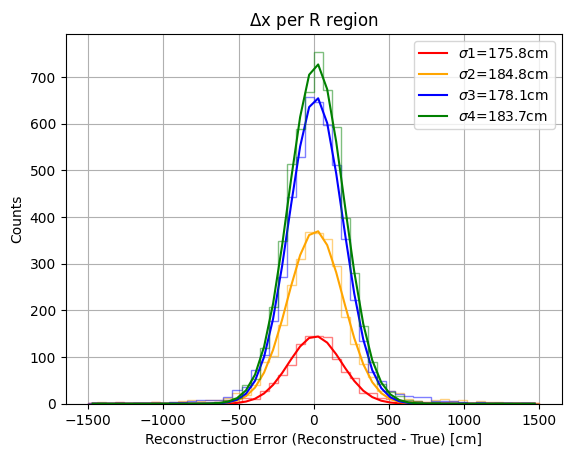

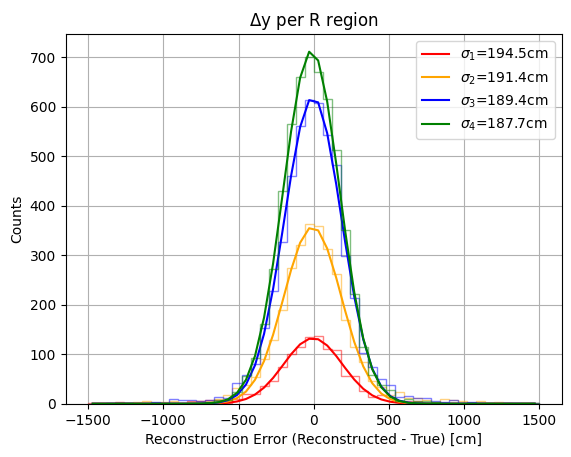

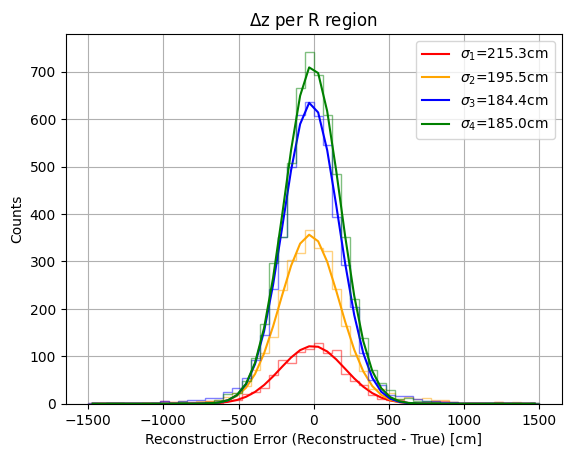

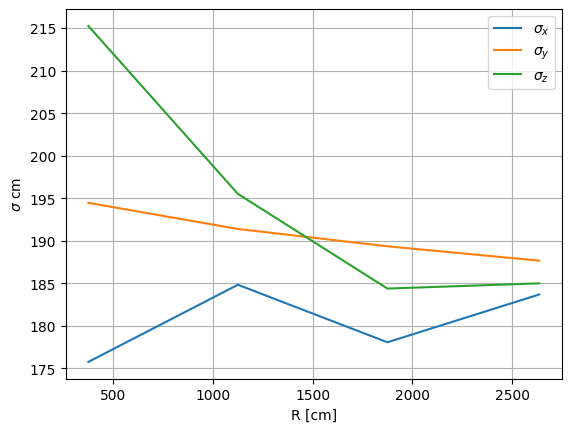

In [29]:

r_regions = [(0, 750), (750, 1500), (1500, 2250), (2250, max(rho_target))]
print("R regions: {}".format(r_regions))

dx = x_recons - x_target
dy = y_recons - y_target
dz = z_recons - z_target
r = np.sqrt(x_recons**2+y_recons**2)
r_binned_data = []
for r_min, r_max in r_regions:
    mask = (r >= r_min) & (r < r_max)
    r_binned_data.append((dx[mask], dy[mask], dz[mask]))

R = []
sigma_Rx = []

color = ['red', 'orange', 'blue', 'green']
for i, (r_min, r_max) in enumerate(r_regions):
    dx_bin, dy_bin, dz_bin = r_binned_data[i]
    R.append((r_min+r_max)/2)
    hist_delPhi_x = plt.hist(dx_bin, bins = 50, range = [-1500, 1500], alpha = 0.5, histtype='step', lw=2, color = color[i]) #label = 'X error, std = {:.1f} [cm]'.format(dx_bin.std(axis=0))
    x_hist_delPhi_x = (hist_delPhi_x[1][1:]+hist_delPhi_x[1][0:-1])/2
    y_hist_delPhi_x = hist_delPhi_x[0]
    xp0 = [y_hist_delPhi_x.max(), xdiff.mean(), xdiff.std()]
    xp, xpcov = curve_fit(gaussian, x_hist_delPhi_x, y_hist_delPhi_x, p0=xp0)
    xfit = gaussian(x_hist_delPhi_x, xp[0], xp[1], xp[2])
    xlabel=f'$\sigma{i+1}$={np.round(xp[2], 1)}cm'
    sigma_Rx.append(xp[2])
    plt.plot(x_hist_delPhi_x, xfit, label=xlabel, color = color[i])

plt.title(f'$\Delta$x per R region')
plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()

R = []

sigma_Ry = []


for i, (r_min, r_max) in enumerate(r_regions):
    dx_bin, dy_bin, dz_bin = r_binned_data[i]
    R.append((phi_min+phi_max)/2)
    hist_delPhi_y = plt.hist(dy_bin, bins = 50, range = [-1500, 1500], alpha = 0.5, histtype='step', lw=2, color = color[i]) # label = 'Y error, std = {:.1f} [cm]'.format(dy_bin.std(axis=0)))
    x_hist_delPhi_y = (hist_delPhi_y[1][1:]+hist_delPhi_y[1][0:-1])/2
    y_hist_delPhi_y = hist_delPhi_y[0]
    yp0 = [y_hist_delPhi_y.max(), ydiff.mean(), ydiff.std()]
    yp, ypcov = curve_fit(gaussian, x_hist_delPhi_y, y_hist_delPhi_y, p0=yp0)
    yfit = gaussian(x_hist_delPhi_y, yp[0], yp[1], yp[2])
    ylabel=f'$\sigma_{i+1}$={np.round(yp[2], 1)}cm'
    sigma_Ry.append(yp[2])
    plt.plot(x_hist_delPhi_y, yfit, label=ylabel, color = color[i])
plt.title(f'$\Delta$y per R region')
plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()
R = []

sigma_Rz = []
for i, (r_min, r_max) in enumerate(r_regions):
    dx_bin, dy_bin, dz_bin = r_binned_data[i]
    R.append((r_min+r_max)/2)
    hist_delPhi_z = plt.hist(dz_bin, bins = 50, range = [-1500, 1500], alpha = 0.5, histtype='step', lw=2, color = color[i]) #label = 'Z reg{:.1f}, std = {:.1f} [cm]'.format(i, dz_bin.std(axis=0)))
    x_hist_delPhi_z = (hist_delPhi_z[1][1:]+hist_delPhi_z[1][0:-1])/2
    y_hist_delPhi_z = hist_delPhi_z[0]
    zp0 = [y_hist_delPhi_z.max(), zdiff.mean(), zdiff.std()]
    zp, zpcov = curve_fit(gaussian, x_hist_delPhi_z, y_hist_delPhi_z, p0=zp0)
    zfit = gaussian(x_hist_delPhi_z, zp[0], zp[1], zp[2])
    zlabel=f'$\sigma_{i+1}$={np.round(zp[2], 1)}cm'
    sigma_Rz.append(zp[2])
    plt.plot(x_hist_delPhi_z, zfit, label=zlabel, color = color[i])
plt.title(f'$\Delta$z per R region')
plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()

plt.plot(R,sigma_Rx, label = '$\sigma_x$')
plt.plot(R, sigma_Ry, label = '$\sigma_y$')
plt.plot(R, sigma_Rz, label = '$\sigma_z$')
plt.xlabel('R [cm]')
plt.ylabel('$\sigma$ cm')
plt.legend()
plt.grid()
plt.show()



R regions: [(0, 750), (750, 1500), (1500, 2250), (2250, np.float32(3022.7952))]


<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:62: SyntaxWarning: invalid escape sequence '\D'
<>:80: SyntaxWarning: invalid escape sequence '\s'
<>:83: SyntaxWarning: invalid escape sequence '\D'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:91: SyntaxWarning: invalid escape sequence '\s'
<>:92: SyntaxWarning: invalid escape sequence '\s'
<>:94: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:62: SyntaxWarning: invalid escape sequence '\D'
<>:80: SyntaxWarning: invalid escape sequence '\s'
<>:83: SyntaxWarning: invalid escape sequence '\D'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:91: SyntaxWarning: invalid escape sequence '\s'
<>:92: SyntaxWarning: invalid escape sequence '\s'
<>:94: SyntaxWarning: invalid e

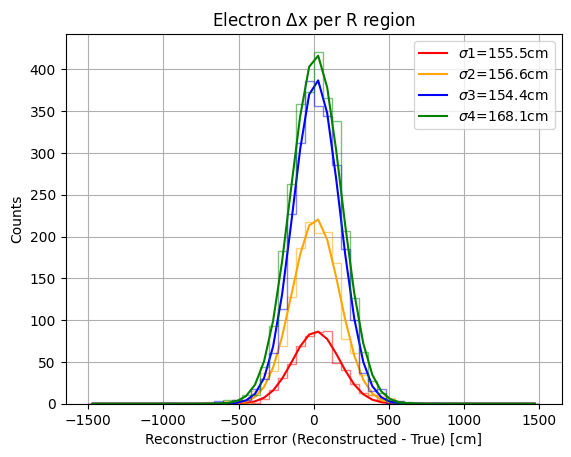

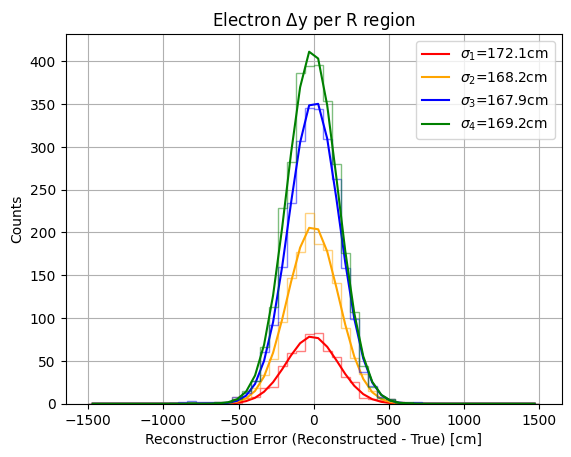

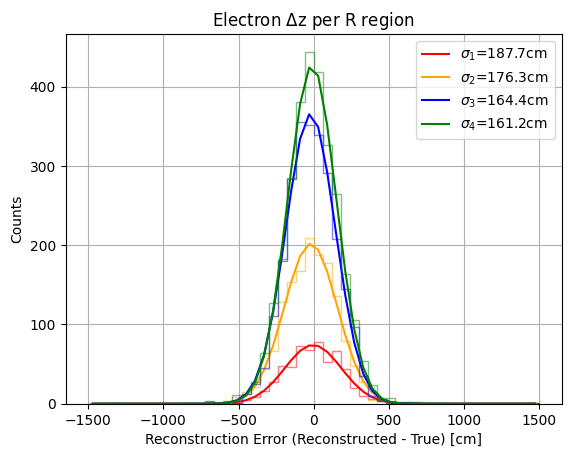

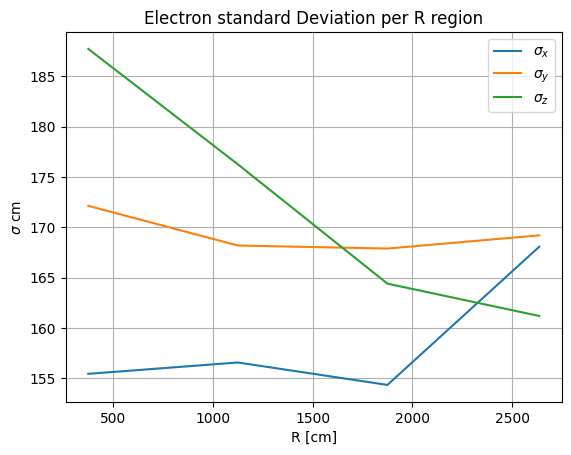

R regions: [(0, 750), (750, 1500), (1500, 2250), (2250, np.float32(3022.7952))]


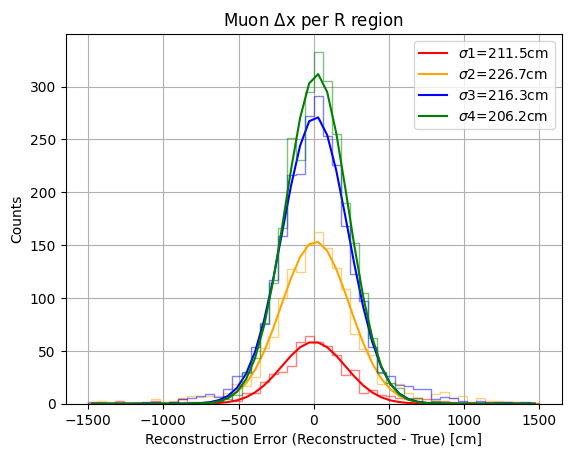

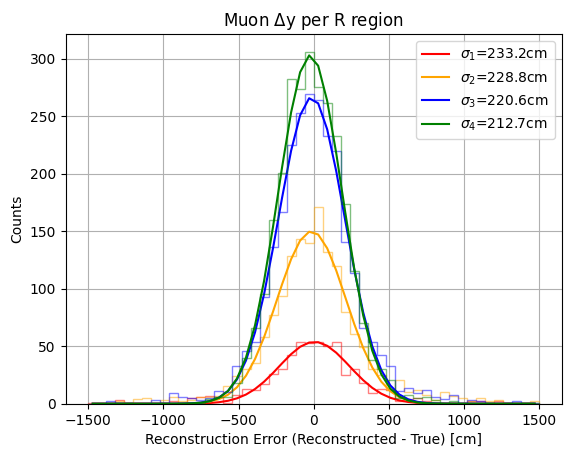

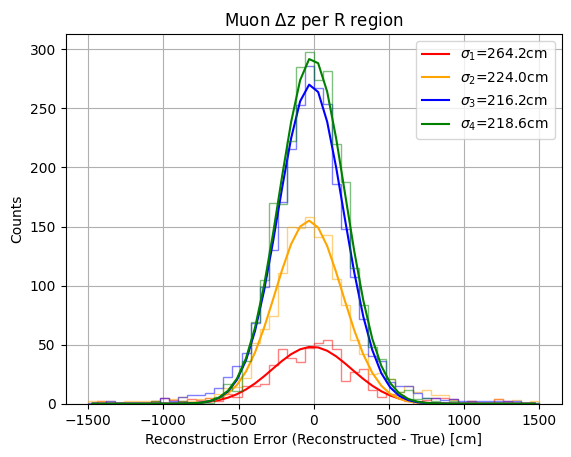

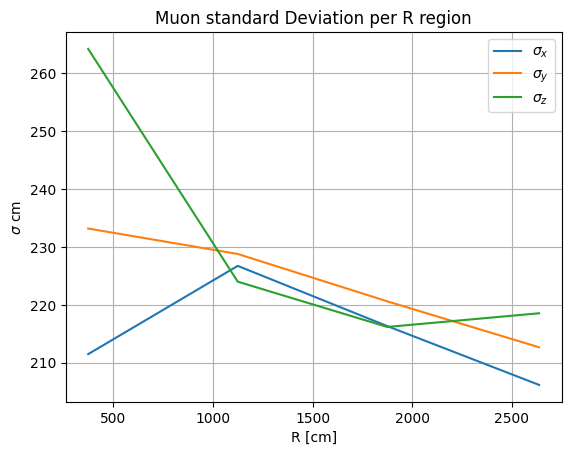

In [30]:
def particle_separator_pos_radial(recons_scaled, targets_scaled, rho_target, particle):

    r_regions = [(0, 750), (750, 1500), (1500, 2250), (2250, max(rho_target))]
    print("R regions: {}".format(r_regions))
    x_recons = recons_scaled[:,1]
    y_recons = recons_scaled[:,2]
    z_recons = recons_scaled[:,3]
    x_target = targets_scaled[:,1]
    y_target = targets_scaled[:,2]
    z_target = targets_scaled[:,3]

    dx = x_recons - x_target
    dy = y_recons - y_target
    dz = z_recons - z_target
    r = np.sqrt(x_recons**2+y_recons**2)
    r_binned_data = []
    for r_min, r_max in r_regions:
        mask = (r >= r_min) & (r < r_max)
        r_binned_data.append((dx[mask], dy[mask], dz[mask]))

    R = []
    sigma_Rx = []

    color = ['red', 'orange', 'blue', 'green']
    for i, (r_min, r_max) in enumerate(r_regions):
        dx_bin, dy_bin, dz_bin = r_binned_data[i]
        R.append((r_min+r_max)/2)
        hist_delPhi_x = plt.hist(dx_bin, bins = 50, range = [-1500, 1500], alpha = 0.5, histtype='step', lw=2, color = color[i]) #label = 'X error, std = {:.1f} [cm]'.format(dx_bin.std(axis=0))
        x_hist_delPhi_x = (hist_delPhi_x[1][1:]+hist_delPhi_x[1][0:-1])/2
        y_hist_delPhi_x = hist_delPhi_x[0]
        xp0 = [y_hist_delPhi_x.max(), xdiff.mean(), xdiff.std()]
        xp, xpcov = curve_fit(gaussian, x_hist_delPhi_x, y_hist_delPhi_x, p0=xp0)
        xfit = gaussian(x_hist_delPhi_x, xp[0], xp[1], xp[2])
        xlabel=f'$\sigma{i+1}$={np.round(xp[2], 1)}cm'
        sigma_Rx.append(xp[2])
        plt.plot(x_hist_delPhi_x, xfit, label=xlabel, color = color[i])

    plt.title(f'{particle} $\Delta$x per R region')
    plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()

    R = []

    sigma_Ry = []


    for i, (r_min, r_max) in enumerate(r_regions):
        dx_bin, dy_bin, dz_bin = r_binned_data[i]
        R.append((phi_min+phi_max)/2)
        hist_delPhi_y = plt.hist(dy_bin, bins = 50, range = [-1500, 1500], alpha = 0.5, histtype='step', lw=2, color = color[i]) # label = 'Y error, std = {:.1f} [cm]'.format(dy_bin.std(axis=0)))
        x_hist_delPhi_y = (hist_delPhi_y[1][1:]+hist_delPhi_y[1][0:-1])/2
        y_hist_delPhi_y = hist_delPhi_y[0]
        yp0 = [y_hist_delPhi_y.max(), ydiff.mean(), ydiff.std()]
        yp, ypcov = curve_fit(gaussian, x_hist_delPhi_y, y_hist_delPhi_y, p0=yp0)
        yfit = gaussian(x_hist_delPhi_y, yp[0], yp[1], yp[2])
        ylabel=f'$\sigma_{i+1}$={np.round(yp[2], 1)}cm'
        sigma_Ry.append(yp[2])
        plt.plot(x_hist_delPhi_y, yfit, label=ylabel, color = color[i])
    plt.title(f'{particle} $\Delta$y per R region')
    plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()
    R = []

    sigma_Rz = []
    for i, (r_min, r_max) in enumerate(r_regions):
        dx_bin, dy_bin, dz_bin = r_binned_data[i]
        R.append((r_min+r_max)/2)
        hist_delPhi_z = plt.hist(dz_bin, bins = 50, range = [-1500, 1500], alpha = 0.5, histtype='step', lw=2, color = color[i]) #label = 'Z reg{:.1f}, std = {:.1f} [cm]'.format(i, dz_bin.std(axis=0)))
        x_hist_delPhi_z = (hist_delPhi_z[1][1:]+hist_delPhi_z[1][0:-1])/2
        y_hist_delPhi_z = hist_delPhi_z[0]
        zp0 = [y_hist_delPhi_z.max(), zdiff.mean(), zdiff.std()]
        zp, zpcov = curve_fit(gaussian, x_hist_delPhi_z, y_hist_delPhi_z, p0=zp0)
        zfit = gaussian(x_hist_delPhi_z, zp[0], zp[1], zp[2])
        zlabel=f'$\sigma_{i+1}$={np.round(zp[2], 1)}cm'
        sigma_Rz.append(zp[2])
        plt.plot(x_hist_delPhi_z, zfit, label=zlabel, color = color[i])
    plt.title(f'{particle} $\Delta$z per R region')
    plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(R, sigma_Rx, label = '$\sigma_x$')
    plt.plot(R, sigma_Ry, label = '$\sigma_y$')
    plt.plot(R, sigma_Rz, label = '$\sigma_z$')
    plt.xlabel('R [cm]')
    plt.ylabel('$\sigma$ cm')
    plt.title(f'{particle} standard Deviation per R region')
    plt.legend()
    plt.grid()
    plt.show()

erho_target = rho_target[eevents]
erecons_scaled = recons_scaled[eevents]
etagrtes_scaled = targets_scaled[eevents]
eparticle = 'Electron'
mrho_target = rho_target[mevents]
mrecons_scaled = recons_scaled[mevents]
mtargets_scaled = targets_scaled[mevents]
mparticle = 'Muon'

particle_separator_pos_radial(erecons_scaled, etargets_scaled, erho_target, eparticle)
particle_separator_pos_radial(mrecons_scaled, mtargets_scaled, mrho_target, mparticle)


<>:64: SyntaxWarning: invalid escape sequence '\p'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:101: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\p'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:101: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1213193/154940880.py:64: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(bin_centers, fitted_curve, label = f'$\phi${i+1}, $\sigma$ = {sigma:.2f}cm', color = color[i])
/tmp/ipykernel_1213193/154940880.py:64: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(bin_centers, fitted_curve, label = f'$\phi${i+1}, $\sigma$ = {sigma:.2f}cm', color = color[i])
/tmp/ipykernel_1213193/154940880.py:66: SyntaxWarning: invalid escape sequence '\p'
  plt.title(f'{particle} Position Resolution per $\phi$ region')
/tmp/ipykernel_1213193/154940880.py:101: SyntaxWarning: inval

(7500, 4)
(7500, 4)


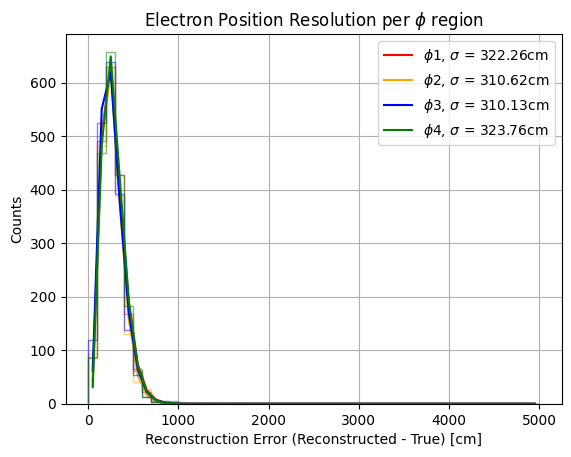

Electron Phi 1 sigma line: [np.float64(322.257486688089), np.float64(310.6209241096931), np.float64(310.1345710731545), np.float64(323.761413936185)]cm


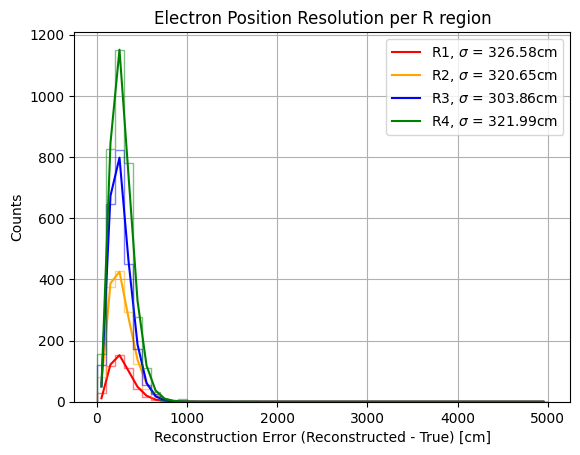

Electron R 1 sigma line: [np.float64(326.5765681956931), np.float64(320.65378378260084), np.float64(303.8586970231117), np.float64(321.9933031280331)] cm


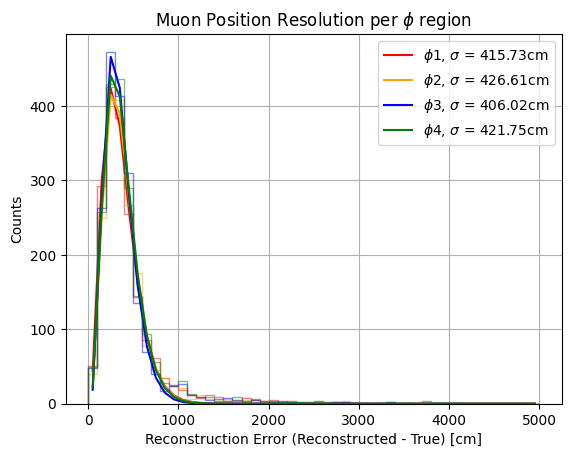

Muon Phi 1 sigma line: [np.float64(415.734240861565), np.float64(426.60832999309554), np.float64(406.0182171222075), np.float64(421.75312884195523)]cm


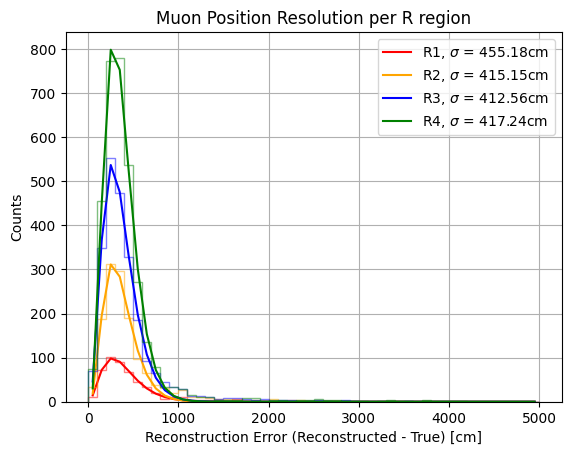

Muon R 1 sigma line: [np.float64(455.1846259178581), np.float64(415.14628107181363), np.float64(412.5576726660592), np.float64(417.23946111590664)] cm
[np.float64(326.5765681956931), np.float64(320.65378378260084), np.float64(303.8586970231117), np.float64(321.9933031280331)]
[991, 1035, 1094, 1295]
[np.float64(322.257486688089), np.float64(310.6209241096931), np.float64(310.1345710731545), np.float64(323.761413936185)]
[1280, 1192, 1092, 1082]
[np.float64(455.1846259178581), np.float64(415.14628107181363), np.float64(412.5576726660592), np.float64(417.23946111590664)]
[1212, 1268, 1425, 1751]
[np.float64(415.734240861565), np.float64(426.60832999309554), np.float64(406.0182171222075), np.float64(421.75312884195523)]
[1671, 1591, 1404, 1462]


In [31]:
from scipy.special import factorial
from scipy.stats import gamma



def cart2pol(x, y):
    rho = np.sqrt(x**2, y**2)
    phi = np.arctan2(y, x)
    return rho, phi

def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return x, y

distance = recons_scaled[:, 1:]-targets_scaled[:,1:]
xdiff = distance[:,0]
ydiff = distance[:,1]
zdiff = distance[:,2]
posR_true, phoPhi_true = cart2pol(targets_scaled[:,1], targets_scaled[:,2])
posR_recon, posPhi_recon = cart2pol(recons_scaled[:,1], recons_scaled[:,2])

posR_diff = posR_recon - posR_true
posPhi_diff = posPhi_recon - posPhi_true

def find_sigma(shape, scale, sigma_fraction = 0.68):
    x_sigma = gamma.ppf(sigma_fraction, a=shape, scale = scale)
    return x_sigma

def fit_function(x, shape, scale, amplitude):
    return amplitude*gamma.pdf(x, a=shape, scale=scale)

def posresparticle(recons_scaled, targets_scaled, particle):
    distance = np.sqrt((recons_scaled[:,1]-targets_scaled[:,1])**2 +(recons_scaled[:,2]-targets_scaled[:,2])**2 + (recons_scaled[:,3]-targets_scaled[:,3])**2)

    phi = np.arctan2(targets_scaled[:,2], targets_scaled[:,1])
    phi_binned_data = []
    phi_regions = [(-np.pi, -np.pi/2), (-np.pi/2, 0), (0, np.pi/2), (np.pi/2, np.pi)]
    for phi_min, phi_max in phi_regions:
        mask = (phi >= phi_min) & (phi < phi_max)
        phi_binned_data.append((distance[mask]))
    
    PHI = []
    sigma_Phi = []
    Phi_bias = []
    color = ['red', 'orange', 'blue', 'green']
    for i, (phi_min, phi_max) in enumerate(phi_regions):
        dis_bin = phi_binned_data[i]
        PHI.append((phi_min+phi_max)/2)
        hist, bin_edges = np.histogram(dis_bin, bins=50, range = [0,5000]) #label = 'X error, std = {:.1f} [cm]'.format(dx_bin.std(axis=0))
        bin_centers = (bin_edges[:-1]+bin_edges[1:])/2

        try:
            p_opt, _ = curve_fit(fit_function, bin_centers, hist, p0 = [2, 500, hist.max()])
            shape, scale, amplitude = p_opt
            fitted_curve = fit_function(bin_centers, shape, scale, amplitude)
        except RuntimeError as e:
            print(f"Fit failed for region {i+1}: {e}")
            fitted_curve = np.zeros_like(hist)
        
        sigma = find_sigma(shape, scale)
        sigma_Phi.append(sigma)
        plt.hist(dis_bin, bins = 50, range = [0, 5000], alpha = 0.5, histtype='step', lw=2, color = color[i])
        plt.plot(bin_centers, fitted_curve, label = f'$\phi${i+1}, $\sigma$ = {sigma:.2f}cm', color = color[i])

    plt.title(f'{particle} Position Resolution per $\phi$ region')
    plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()
    print(f'{particle} Phi 1 sigma line: {sigma_Phi}cm')
    r= np.sqrt(targets_scaled[:,1]**2+targets_scaled[:,2]**2)
    r_binned_data = []
    r_regions = [(0, 750), (750, 1500), (1500, 2250), (2250, max(rho_target))]
    for r_min, r_max in r_regions:
        mask = (r >= r_min) & (r < r_max)
        r_binned_data.append((distance[mask]))
    
    R = []
    sigma_R = []
    R_bias = []
    color = ['red', 'orange', 'blue', 'green']
    for i, (r_min, r_max) in enumerate(r_regions):
        dis_bin = r_binned_data[i]
        R.append((phi_min+phi_max)/2)
        hist, bin_edges = np.histogram(dis_bin, bins=50, range = [0,5000]) #label = 'X error, std = {:.1f} [cm]'.format(dx_bin.std(axis=0))
        bin_centers = (bin_edges[:-1]+bin_edges[1:])/2

        try:
            p_opt, _ = curve_fit(fit_function, bin_centers, hist, p0 = [2, 500, hist.max()])
            shape, scale, amplitude = p_opt
            fitted_curve = fit_function(bin_centers, shape, scale, amplitude)
        except RuntimeError as e:
            print(f"Fit failed for region {i+1}: {e}")
            fitted_curve = np.zeros_like(hist)
        
        sigma = find_sigma(shape, scale)
        sigma_R.append(sigma)
        plt.hist(dis_bin, bins = 50, range = [0, 5000], alpha = 0.5, histtype='step', lw=2, color = color[i])
        plt.plot(bin_centers, fitted_curve, label = f'R{i+1}, $\sigma$ = {sigma:.2f}cm', color = color[i])

    plt.title(f'{particle} Position Resolution per R region')
    plt.xlabel('Reconstruction Error (Reconstructed - True) [cm]')
    plt.ylabel('Counts')
    plt.legend()
    plt.grid()
    plt.show()

    print(f'{particle} R 1 sigma line: {sigma_R} cm')
    return sigma_R, sigma_Phi



eevents = np.where(labels ==0)
mevents = np.where(labels ==1)
eparticle = 'Electron'
erecons_scaled = recons_scaled[eevents]
etargets_scaled = targets_scaled[eevents]
print(erecons_scaled.shape)
print(etargets_scaled.shape)
mparticle = 'Muon'
mrecons_scaled = recons_scaled[mevents]
mtargets_scaled = targets_scaled[mevents]

esigma_r, esigma_phi = posresparticle(erecons_scaled, etargets_scaled, eparticle)
msigma_r, msigma_phi = posresparticle(mrecons_scaled, mtargets_scaled, mparticle)
print(esigma_r)
old_re = [991, 1035, 1094, 1295]
print(old_re)
old_phie = [1280, 1192, 1092, 1082]
print(esigma_phi)
print(old_phie)
old_rm = [1212, 1268, 1425, 1751]
print(msigma_r)
print(old_rm)
old_phim = [1671, 1591, 1404, 1462]
print(msigma_phi)
print(old_phim)


In [32]:
#500 MeV energy value resolution for E, x, y, z
#Targets_scaled index is 1185 for small dataset

def particle500MeVRes(particle, recons_scaled, targets_scaled):
    for i in range(len(targets_scaled[:,0])):
        if np.round(targets_scaled[i,0]) == 500:
                    index = i
                    break
    print(f'Energy of event: {targets_scaled[index,0]:.2f} MeV. Index: {index}')
    Ediff = ((recons_scaled[index,0]-targets_scaled[index,0])/targets_scaled[index,0])*100
    Xdiff = recons_scaled[index,0]-targets_scaled[index,0]
    Ydiff = recons_scaled[index,1]-targets_scaled[index,1]
    Zdiff = recons_scaled[index,2]-targets_scaled[index,2]
    Totdiff = np.sqrt(Xdiff**2+Ydiff**2+Zdiff**2)

    print(f'{particle} Energy resolution: {Ediff:.2f} %')
    print(f'{particle} X resolution: {Xdiff:.2f} cm')
    print(f'{particle} Y resolution: {Ydiff:.2f} cm')
    print(f'{particle} Z resolution: {Zdiff:.2f} cm')
    print(f'{particle} Total pos resolution: {Totdiff:.2f} cm')

eparticle = 'Electron'
mparticle = 'Muon'
erecons = recons_scaled[eevents]
mrecons = recons_scaled[mevents]
etargets = targets_scaled[eevents]
mtargets = targets_scaled[mevents]
particle = 'Combined'
particle500MeVRes(eparticle, erecons, etargets)
particle500MeVRes(mparticle, mrecons, mtargets)
particle500MeVRes(particle, recons_scaled, targets_scaled)


Energy of event: 500.27 MeV. Index: 763
Electron Energy resolution: -12.43 %
Electron X resolution: -62.18 cm
Electron Y resolution: -2.29 cm
Electron Z resolution: 67.53 cm
Electron Total pos resolution: 91.82 cm
Energy of event: 500.31 MeV. Index: 94
Muon Energy resolution: -6.39 %
Muon X resolution: -31.98 cm
Muon Y resolution: 237.46 cm
Muon Z resolution: 284.34 cm
Muon Total pos resolution: 371.84 cm
Energy of event: 500.27 MeV. Index: 763
Combined Energy resolution: -12.43 %
Combined X resolution: -62.18 cm
Combined Y resolution: -2.29 cm
Combined Z resolution: 67.53 cm
Combined Total pos resolution: 91.82 cm
